# Assignment 2

## Question 1 [15 Pts]:

Suppose data $\{x_i\}_{i = 1}^{i = n}$ is drawn from a normal distribution of _known_ standard deviation $\sigma$ and _unknown_ mean $\mu$
- Derive the MLE estimate $\mu_{\text{MLE}}$
- Derive the MAP estimate $\mu_{\text{MAP}}$ assuming the prior is also a normal distribution with mean $\tau$ and standard deviation $\omega$. What happens as $n \rightarrow \infty$?


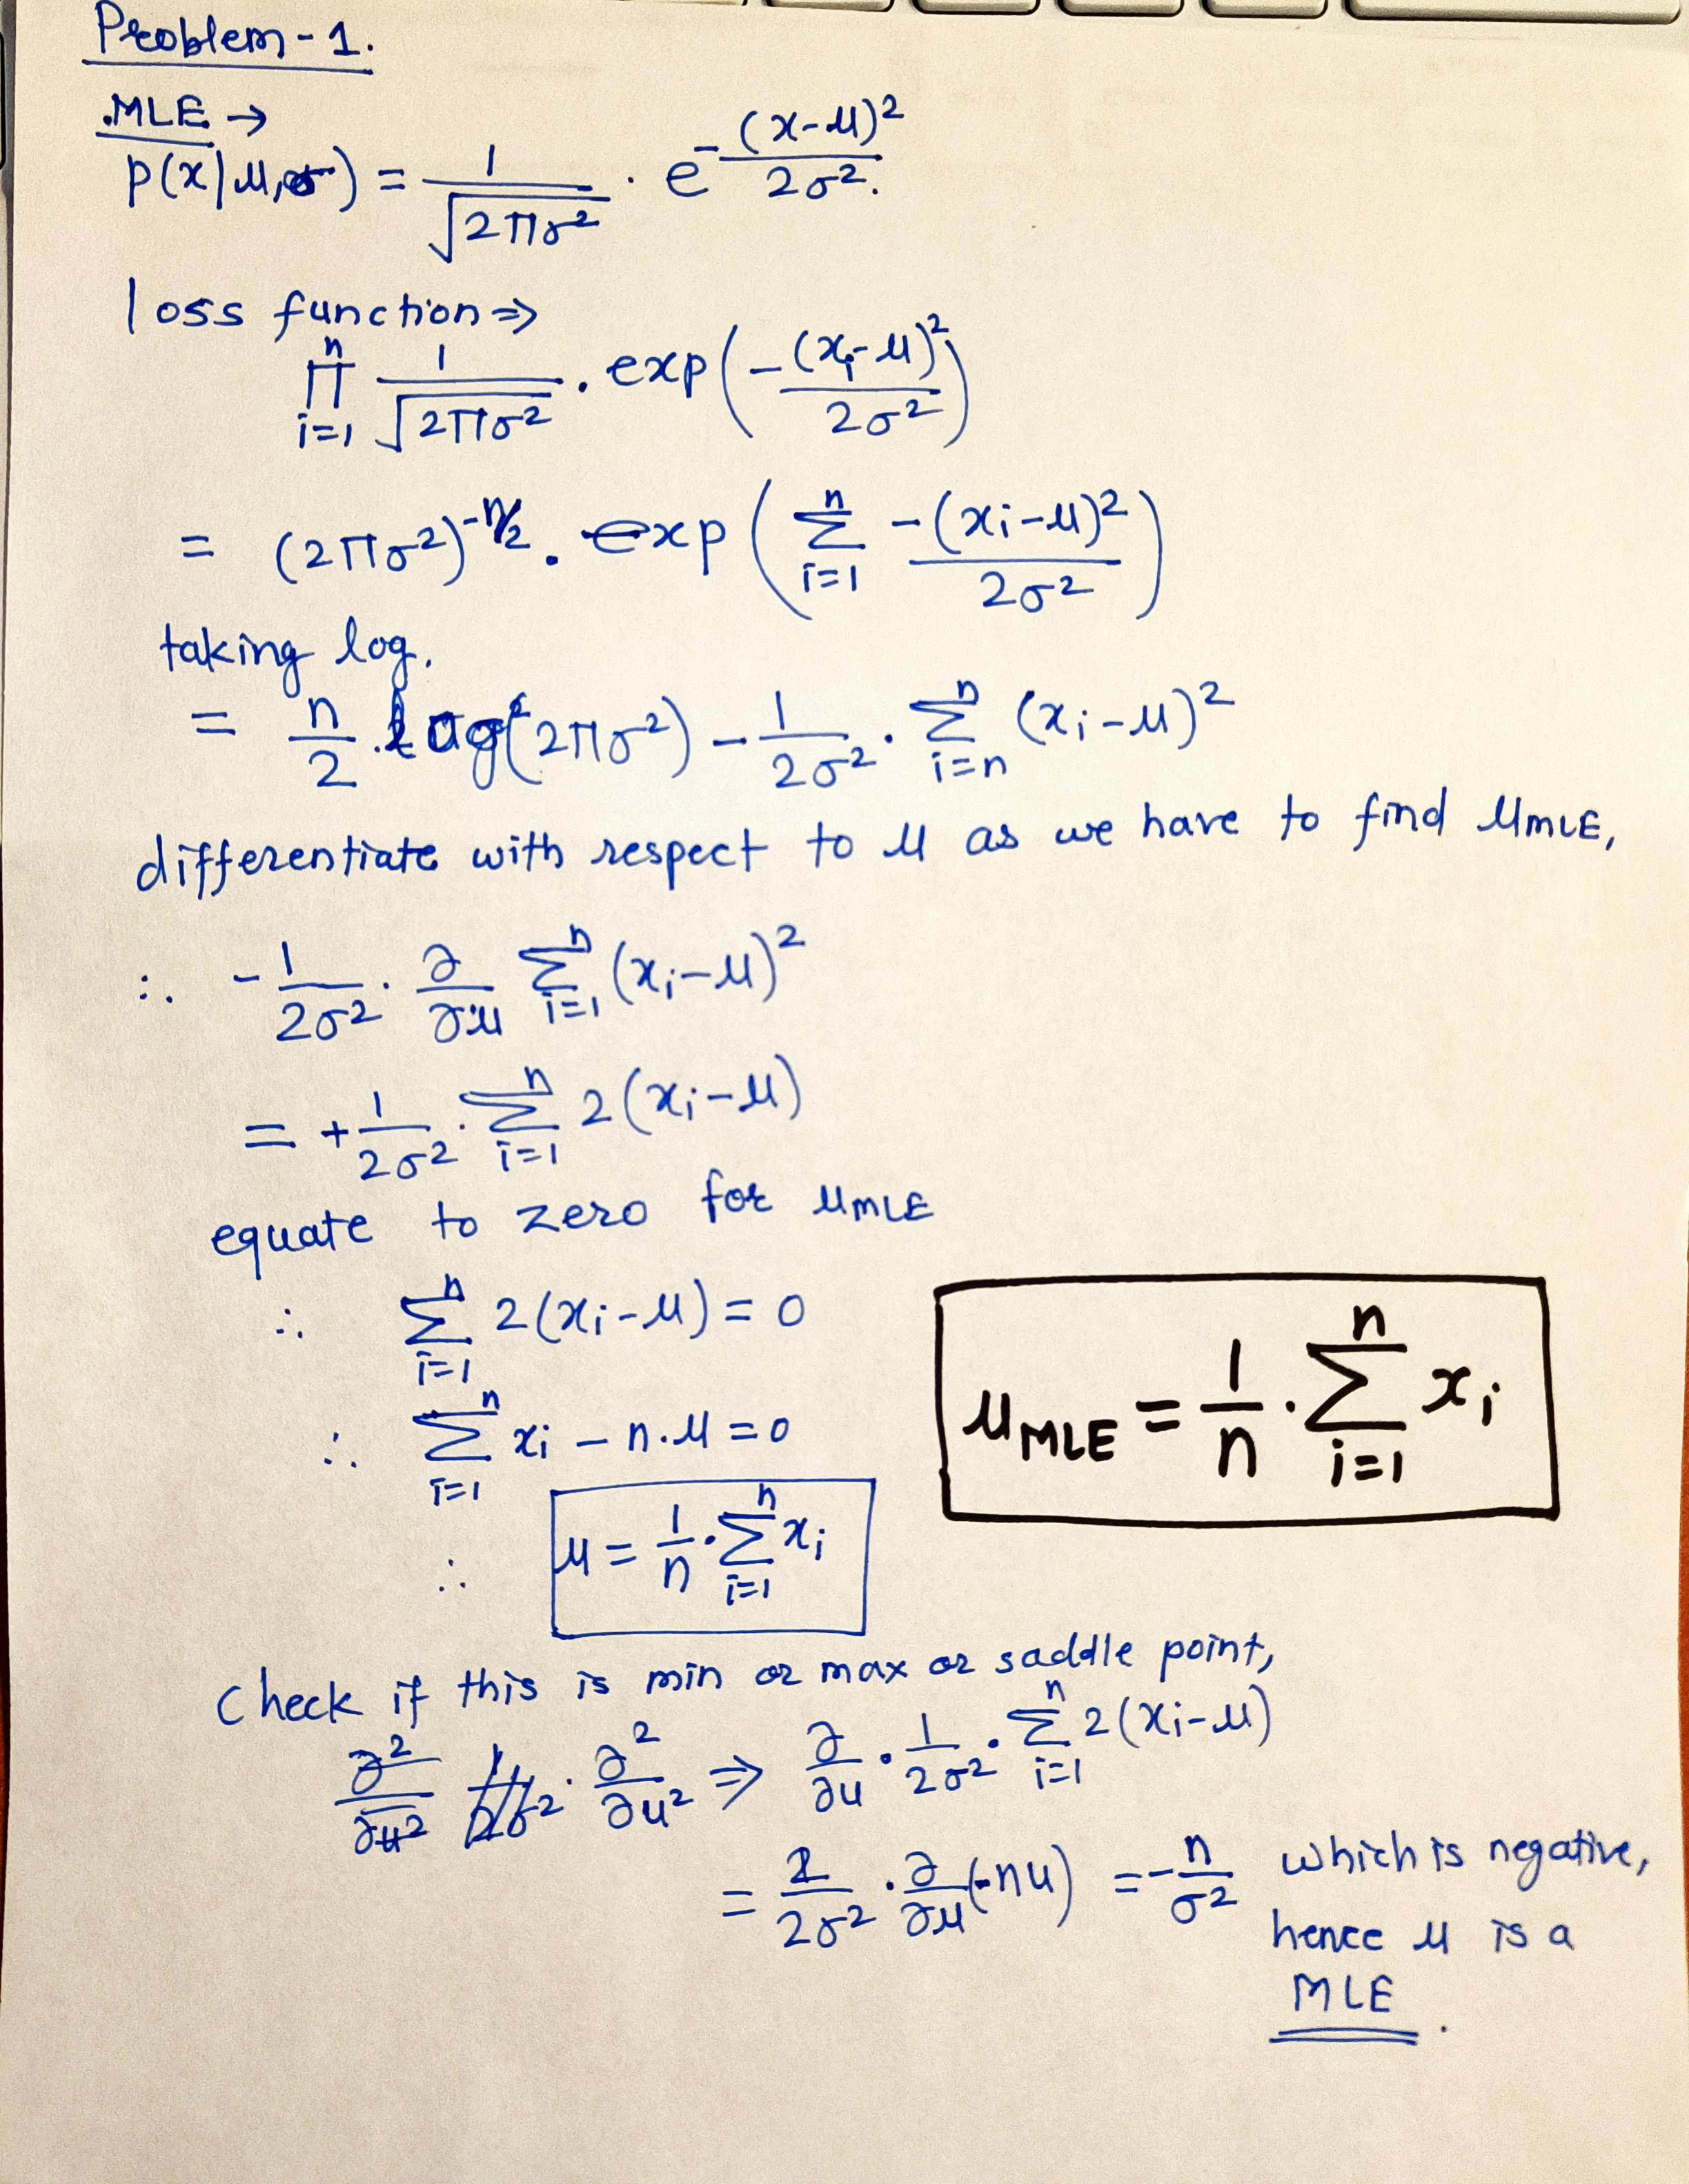

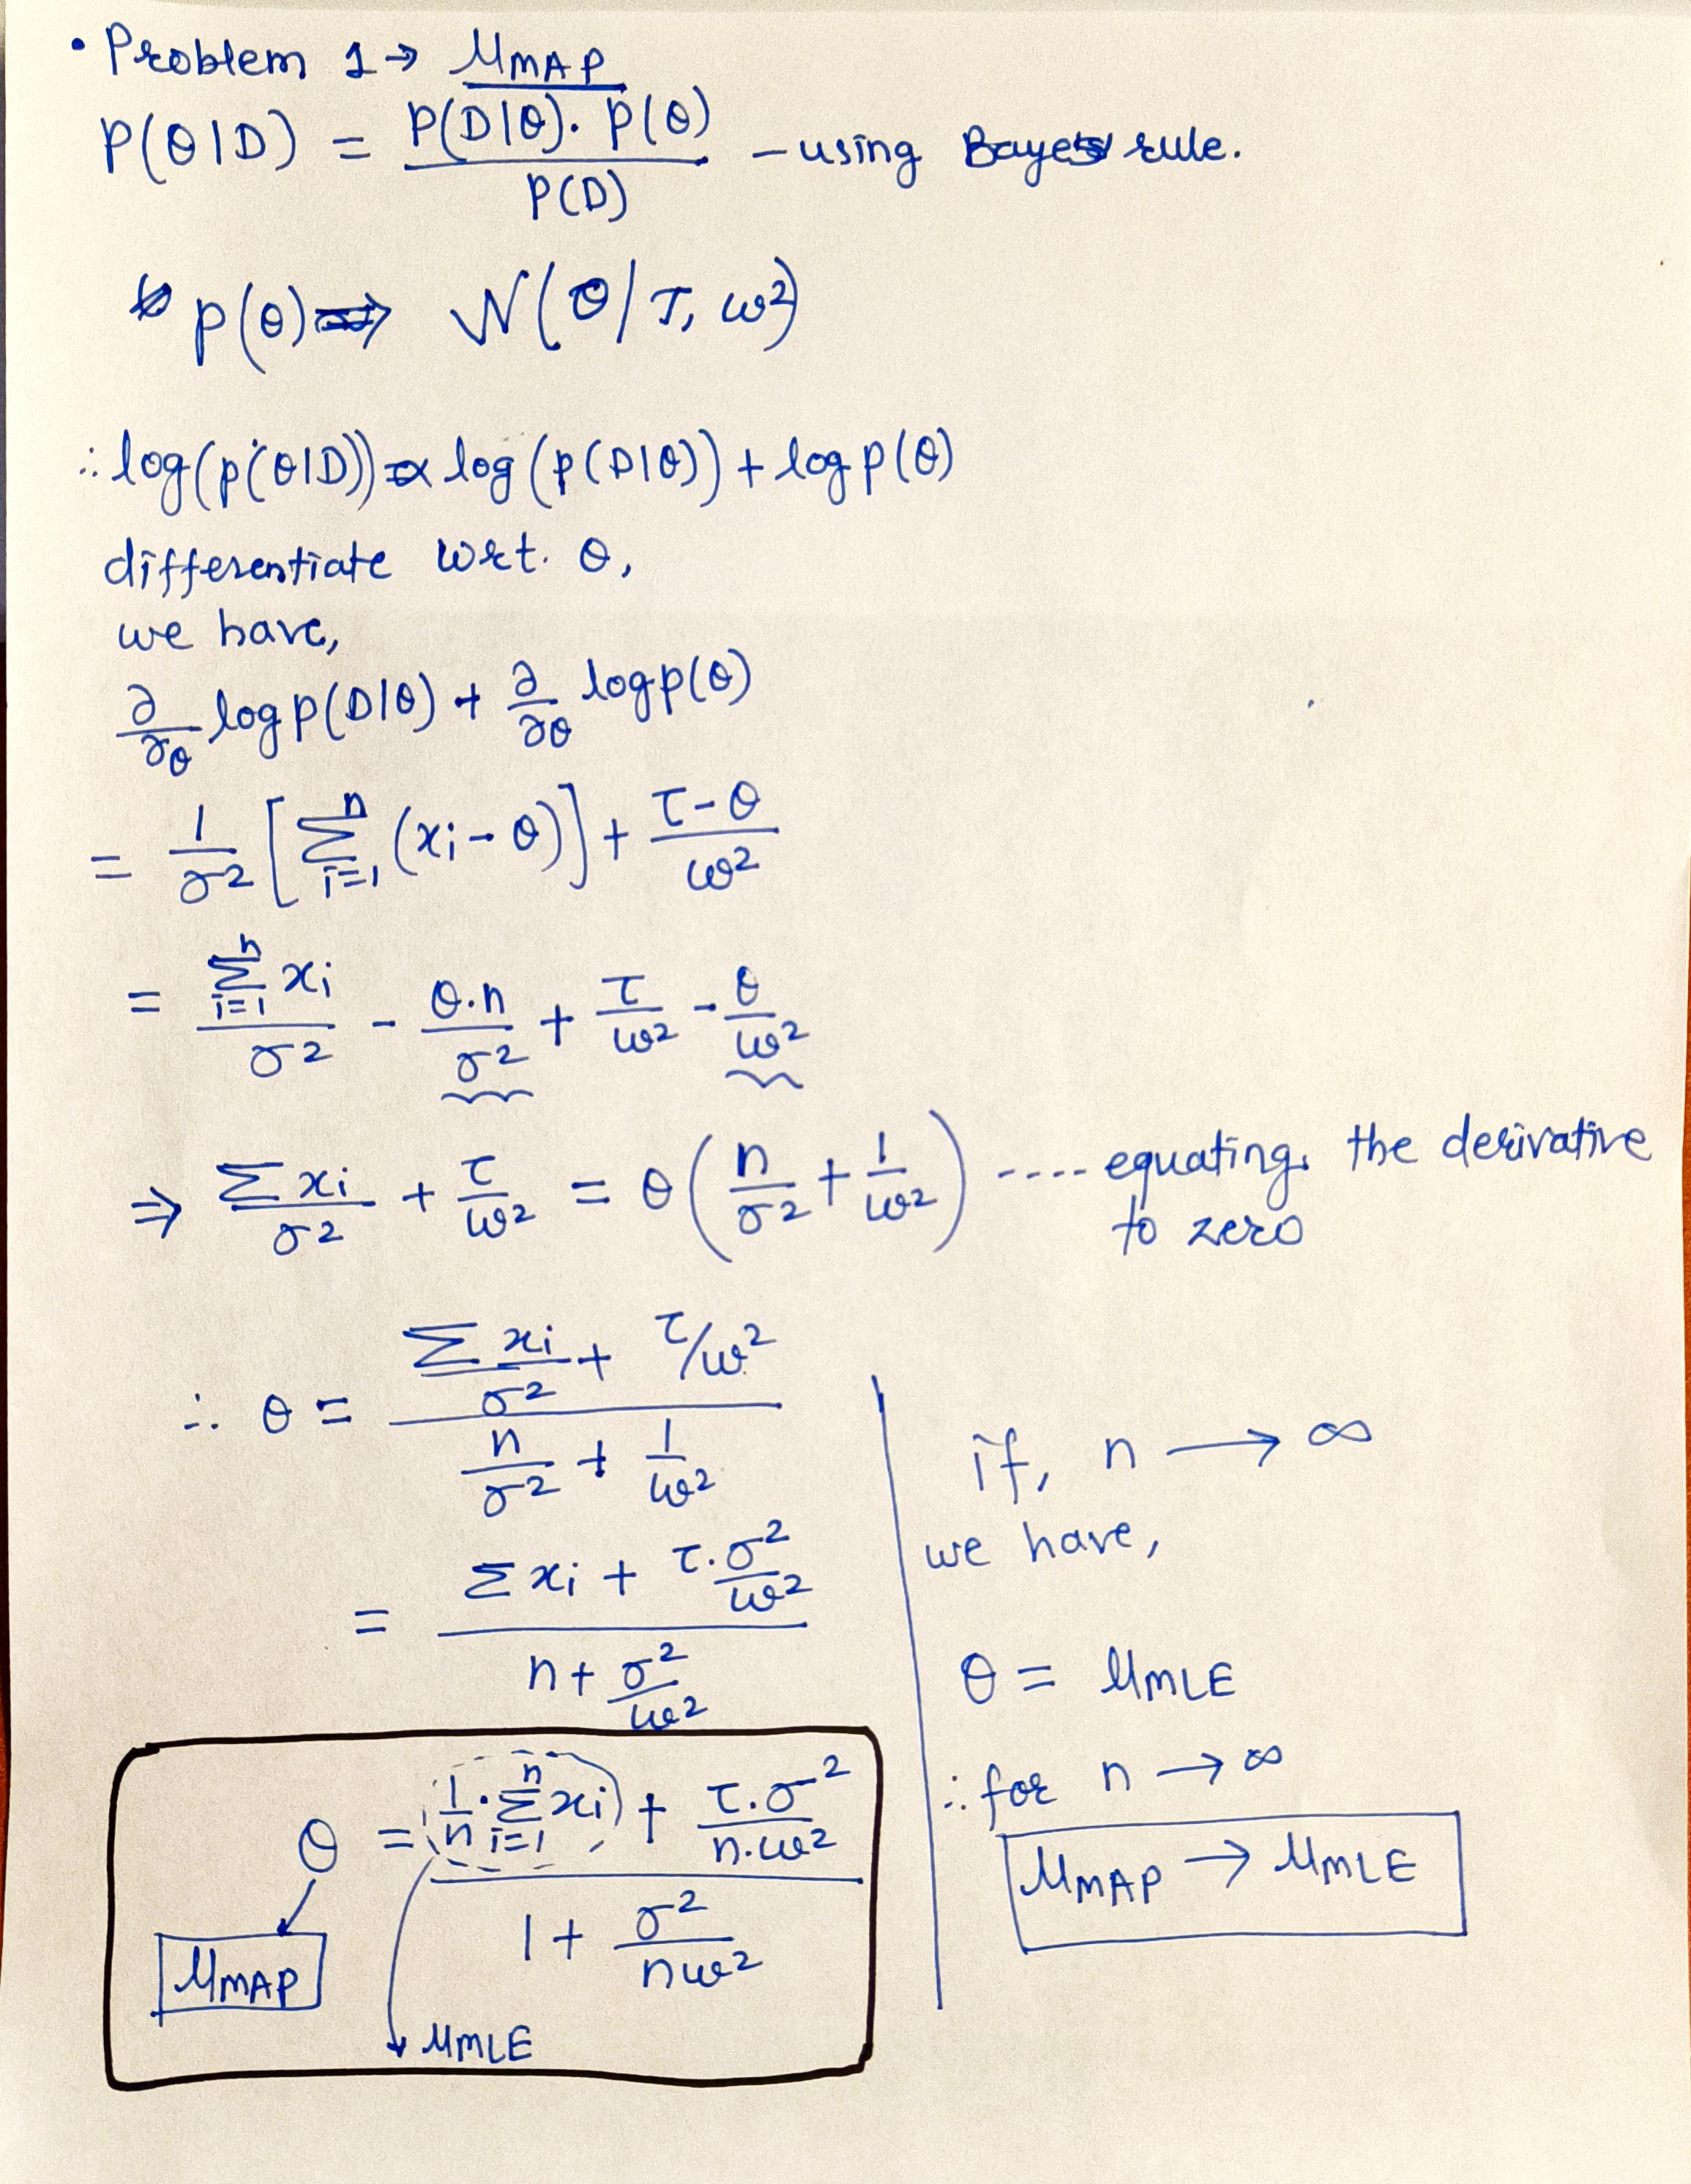

## Answer


## Question 2 [30 Pts]:

Consider a Bayesian linear regression model where the outputs $y$ are distributed according to a Gaussian likelihood $p(y\lvert x, \alpha, \beta, \gamma)$ corresponding to a linear model $y = \alpha x + \beta + \epsilon$. Here $\gamma$ represents the noise level in the observed data, i.e. it corresponds to the precision of the data likelihood. In this case, the likelihood can be further expressed as:

$$p(y\lvert x, \alpha, \beta, \gamma) = (\sqrt{\frac{\gamma}{2\pi}})^n\exp(-\frac{\gamma(\sum_{i=1}^n\|y_i - x_i\alpha - \beta\|^2_2)}{2})$$

In a Bayesian setting we would like to assume prior distributions on the unknown parameters $\alpha$, $\beta$ and $\gamma$. Here we assume $p(\alpha) = \mathcal{N}(\mu_{\alpha}, \sigma_{\alpha})$, $p(\beta) = \mathcal{N}(\mu_{\beta}, \sigma_{\beta})$ and $p(\gamma) = \textrm{Gam}(\tau, \omega)$ is a Gamma distribution.

Please write down the posterior conditional distribution for each of those parameters, i.e.,

$p(\alpha\lvert x, y, \beta, \gamma)$

$p(\beta\lvert x, y, \alpha, \gamma)$

$p(\gamma\lvert x, y, \alpha, \beta)$

Comment on your results.

[**HINT**: Might be easier to work with the $\log$ of the posterior, and "complete the square" to identify the distribution]


Part 1:
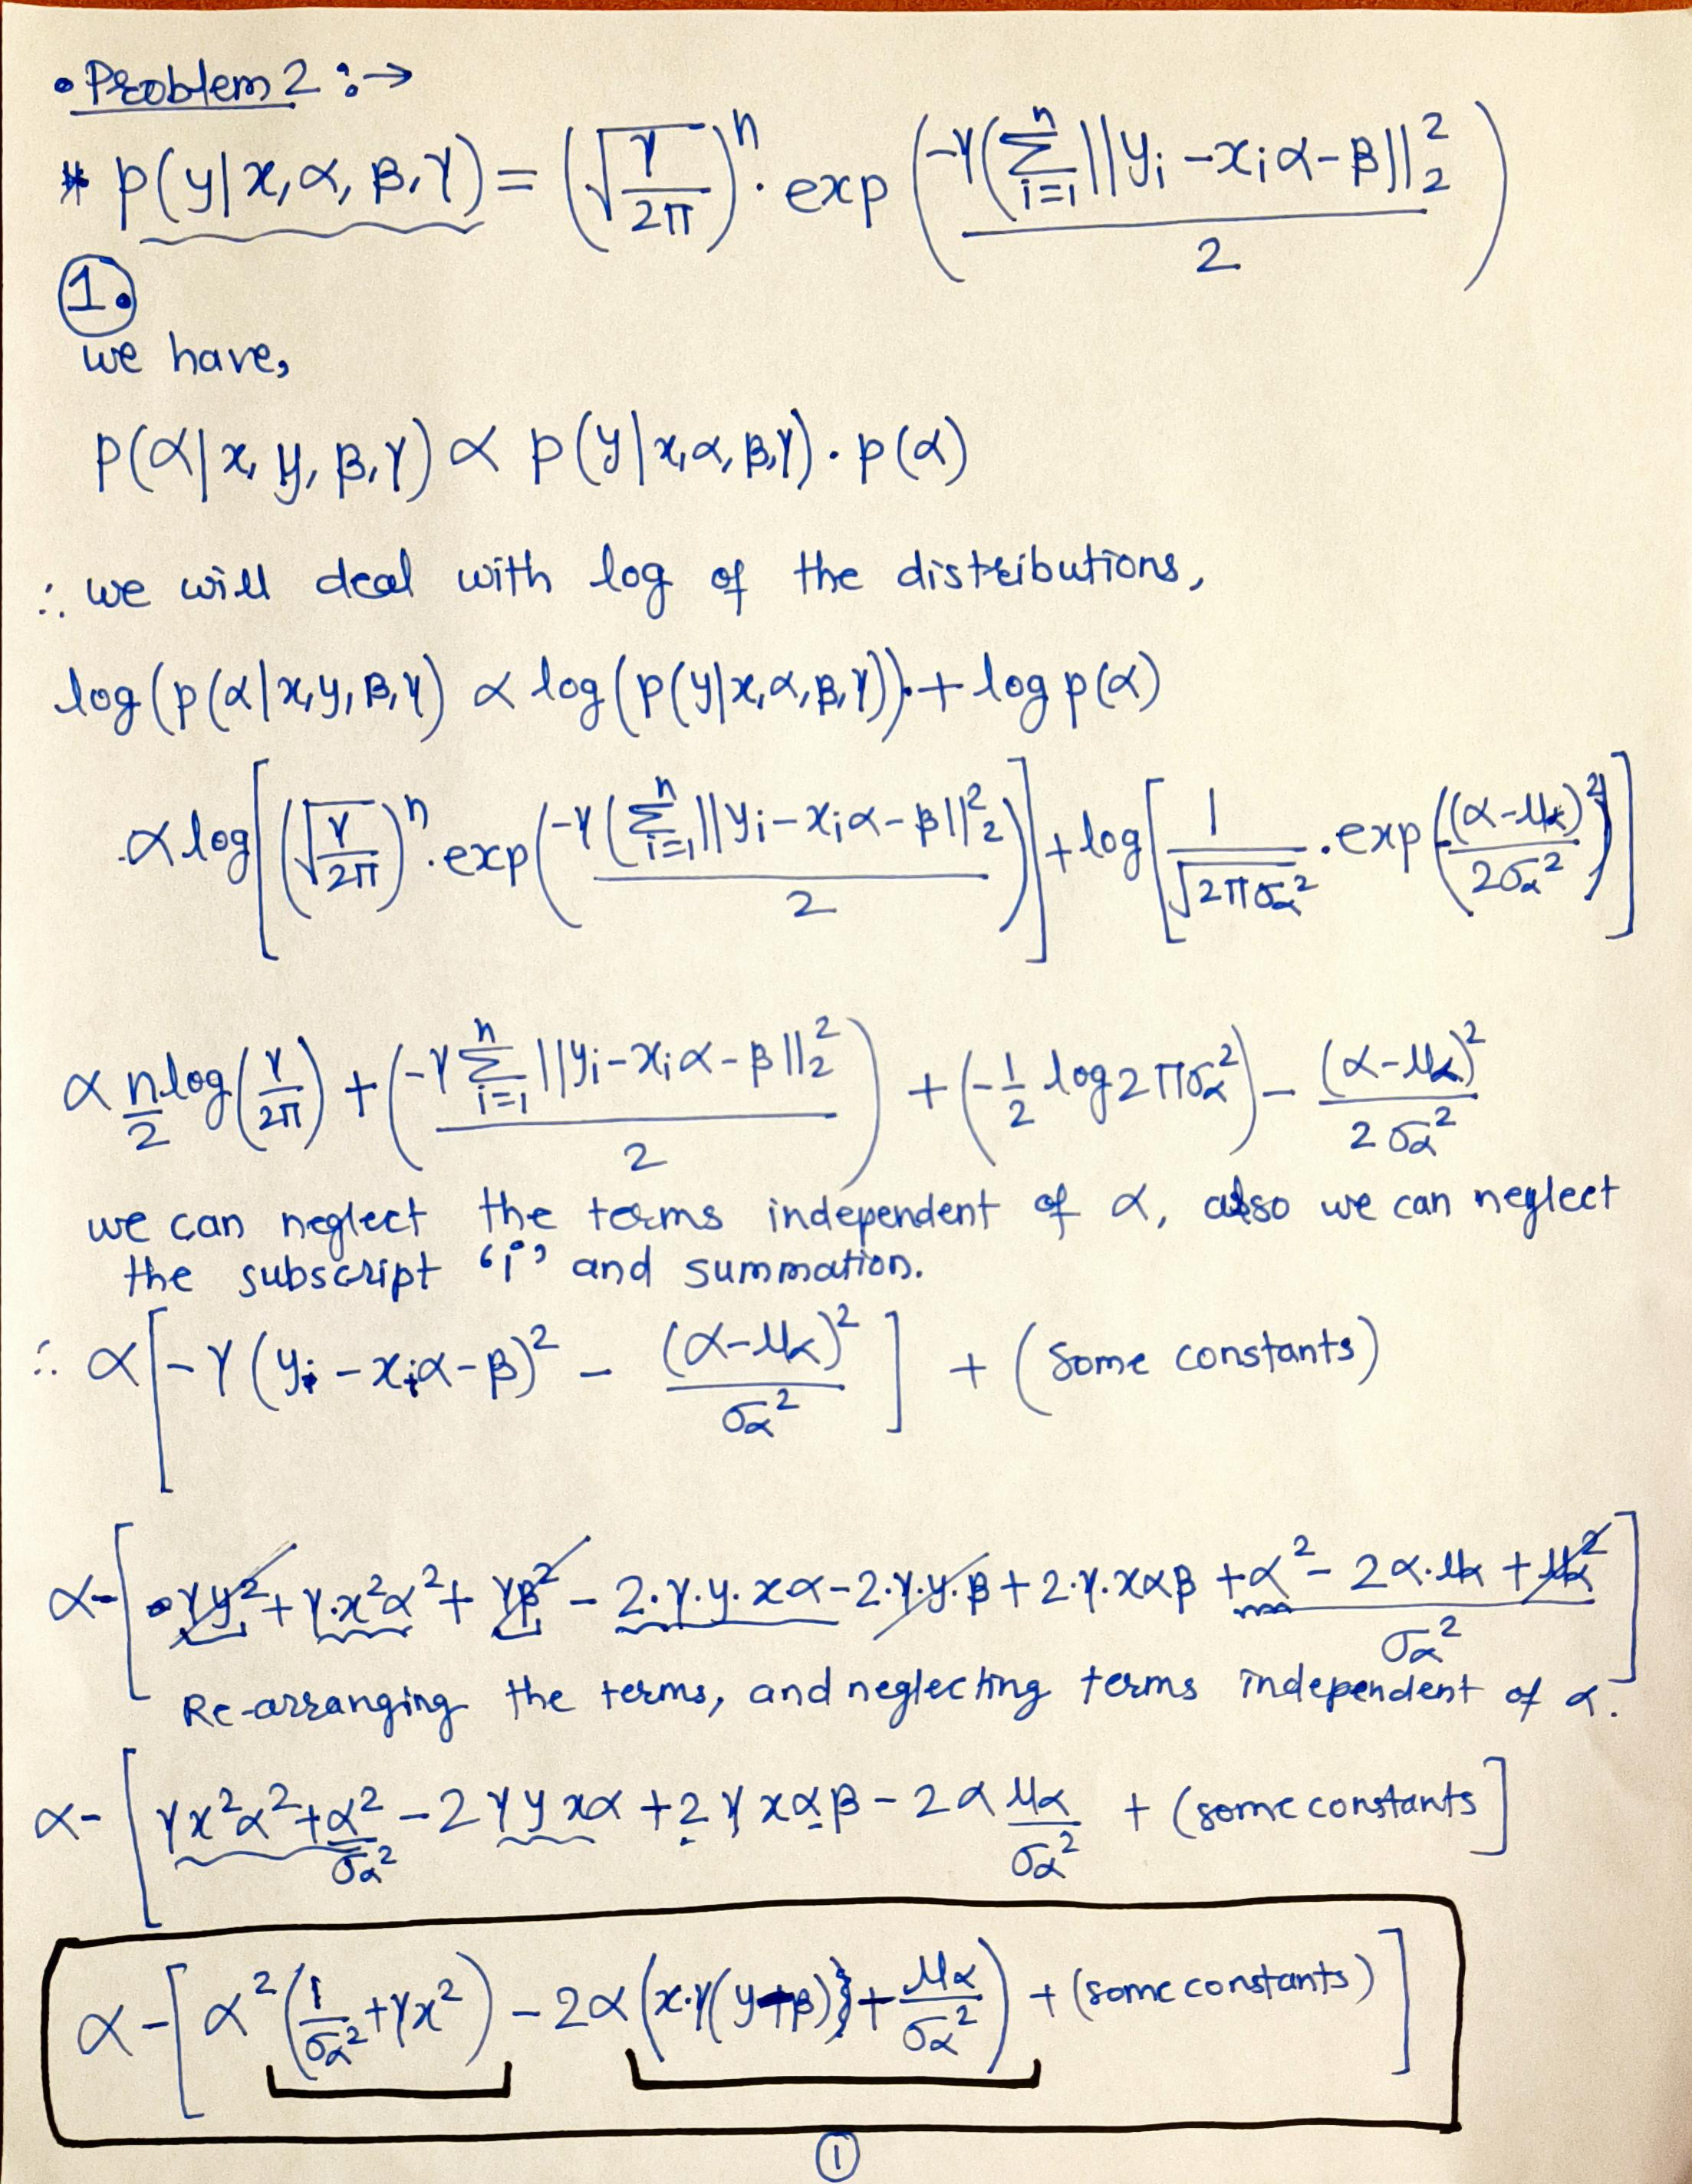

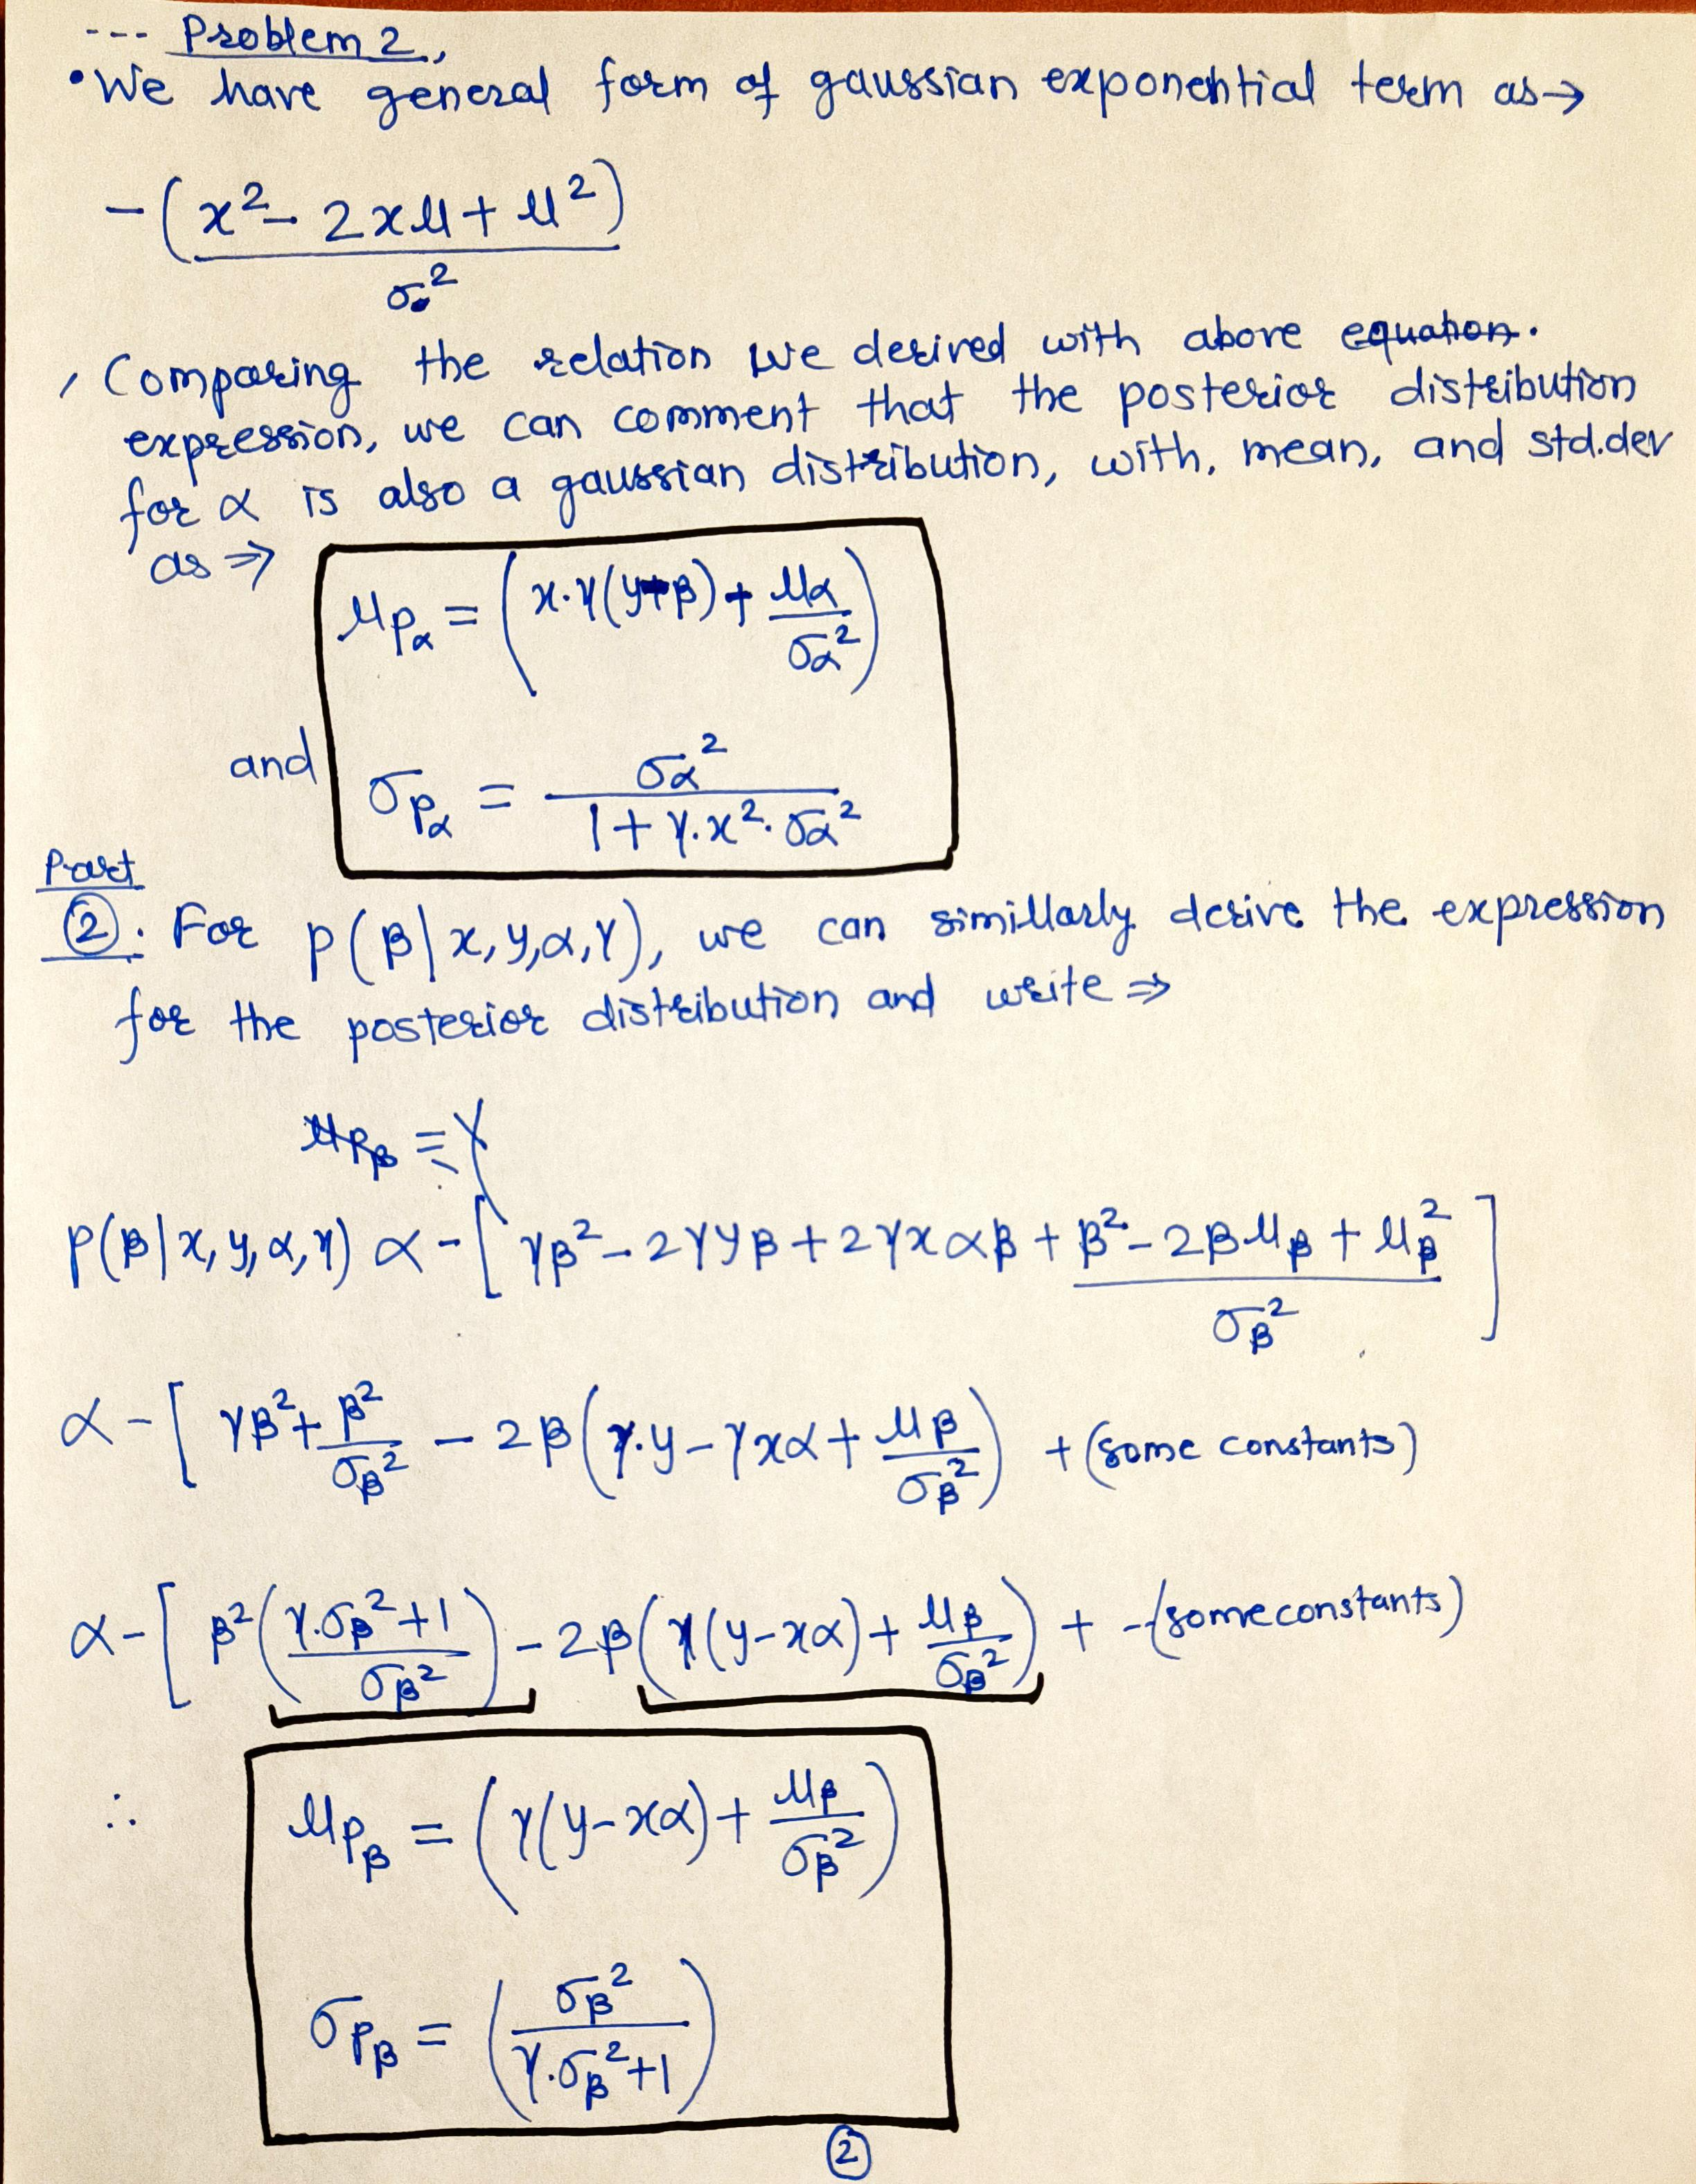

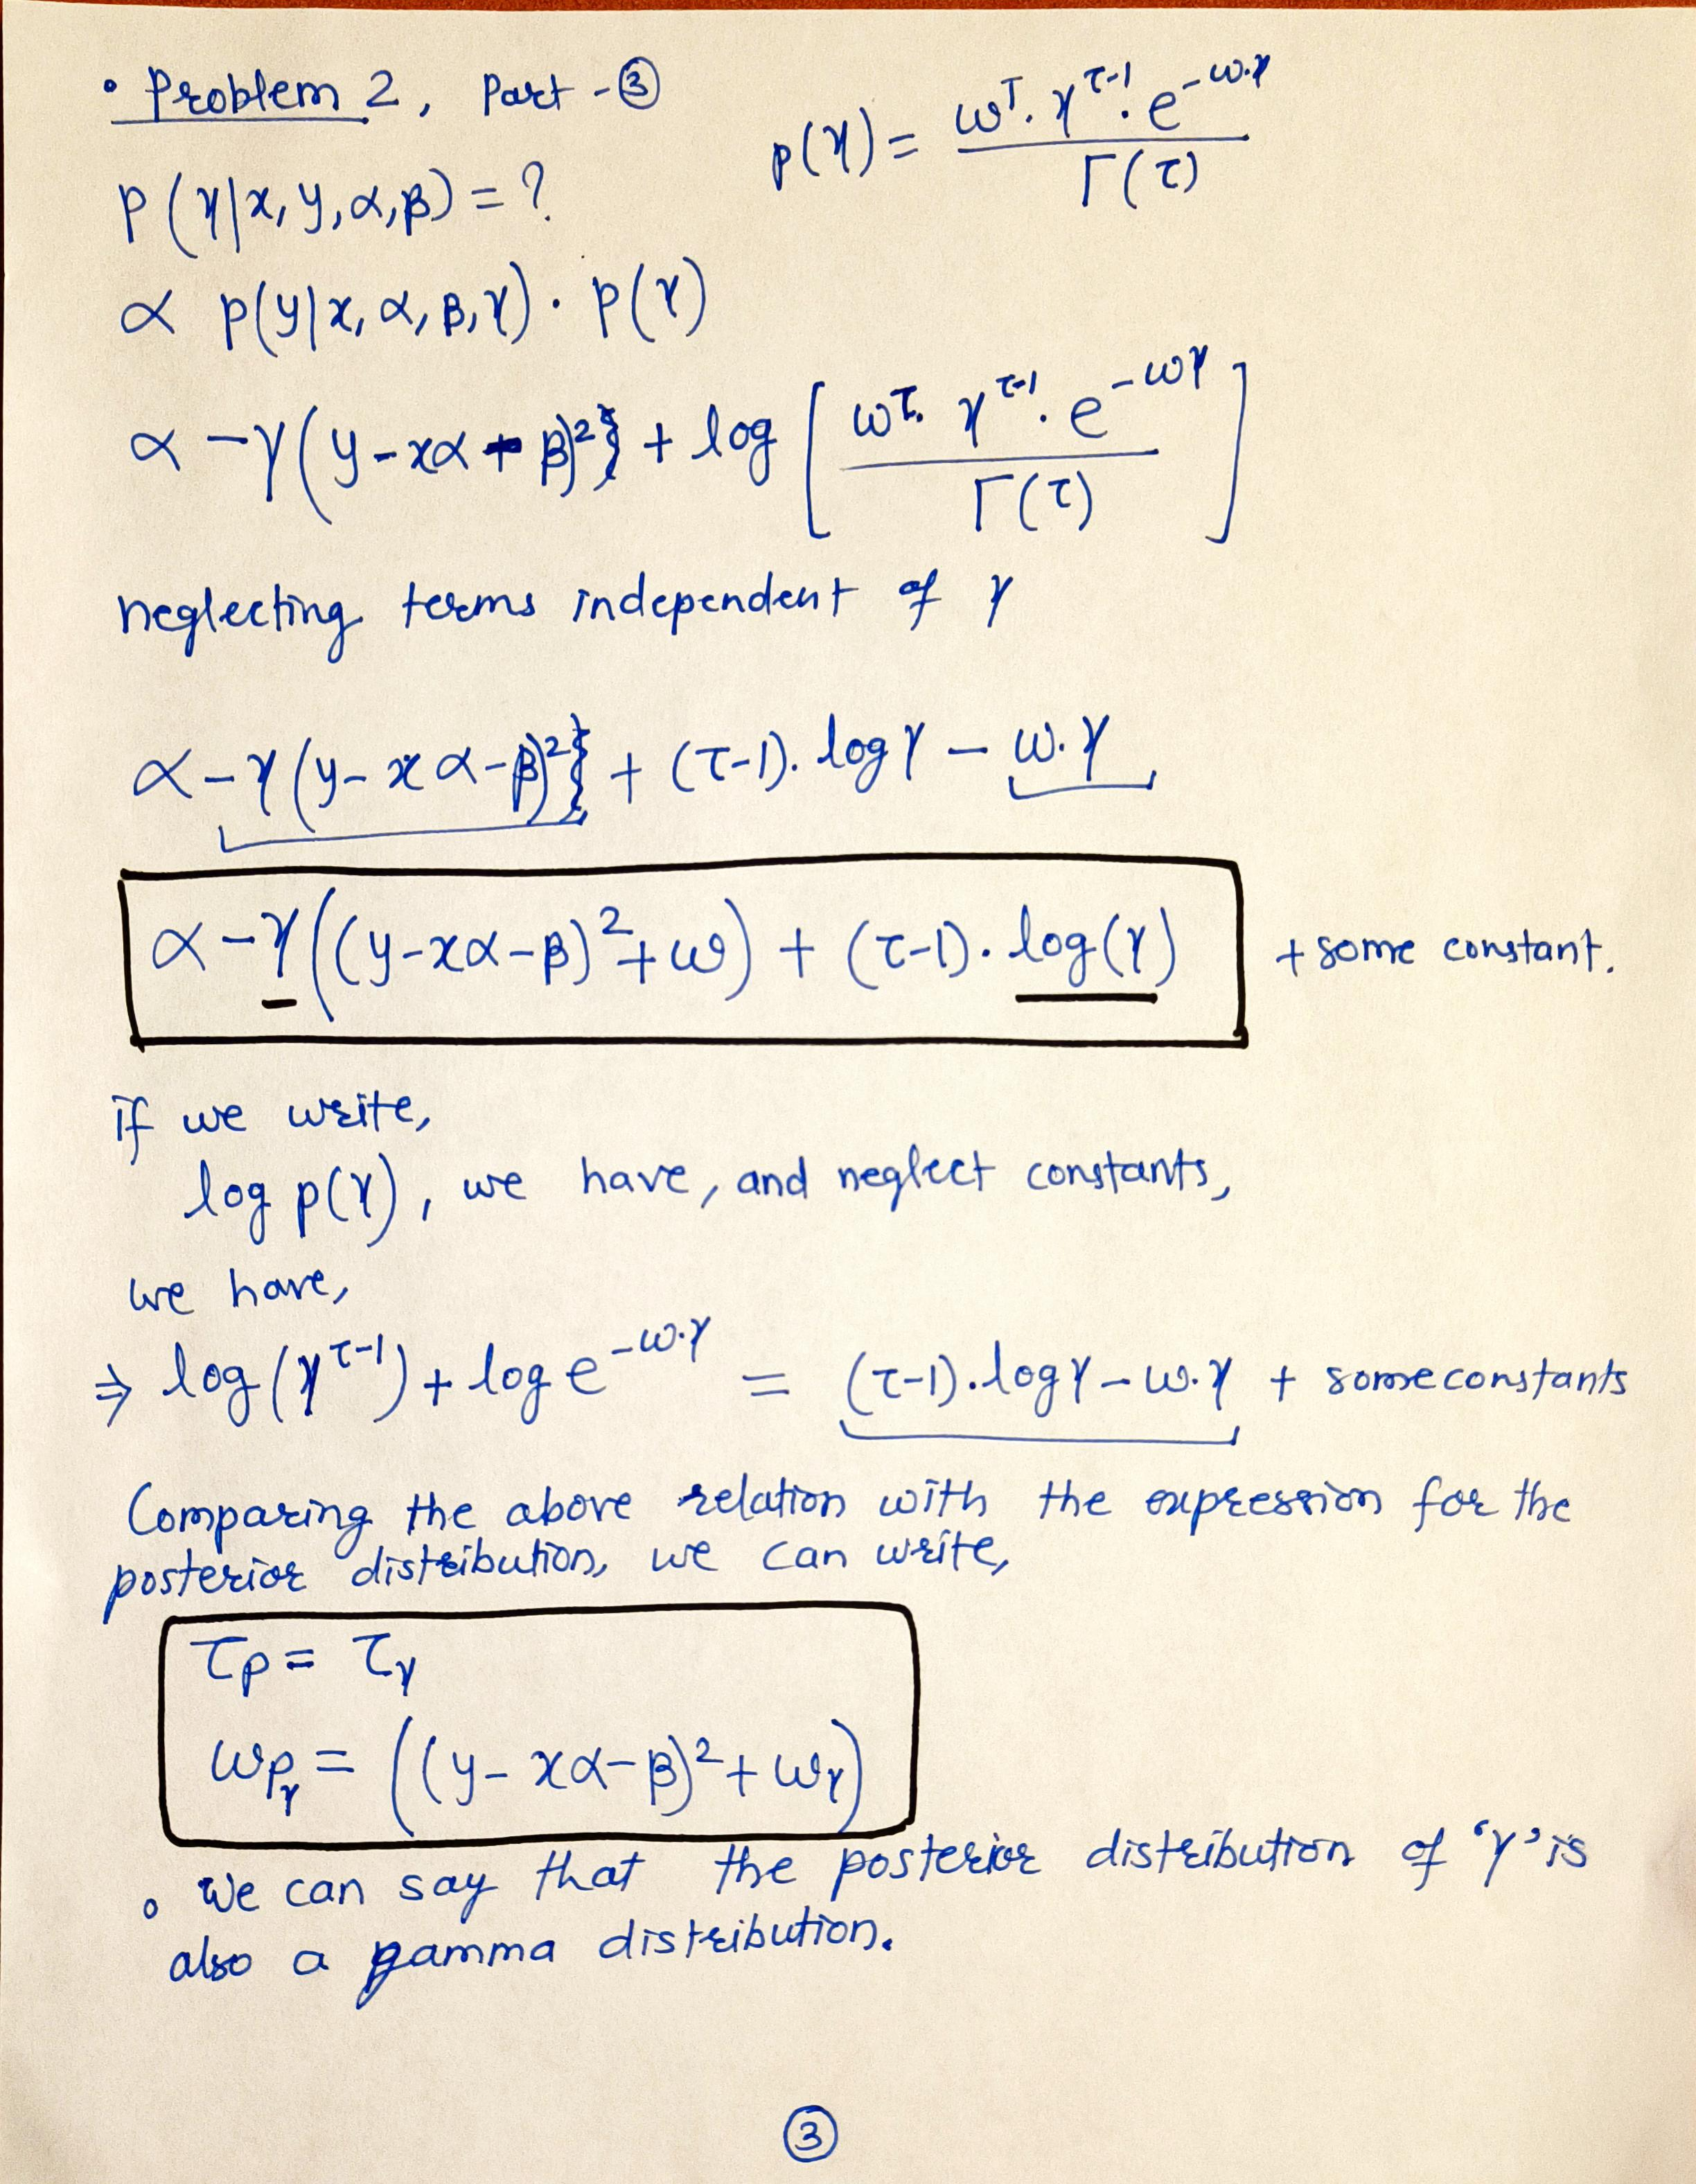

## Answer

## Question 3 [15 Pts]:

Consider the Bayesian linear regression model with
$$p(y\mid x,w) = \mathcal{N}(y\mid w^{T}\phi(x),\alpha^{-1}I), \ p(w)=\mathcal{N}(w\mid 0,\beta^{-1}I),$$

with $\alpha = 0.5, \beta  = 0.1$. Generate a set of $N = 400$ noisy observations by uniformly sampling

$$y(x) = \sin(\pi x) + \sin(2 \pi x) + \sin(5 \pi x)\quad x\in[-1,1]$$

Once you've created the observations, perturb the data with a normal distribution with standard deviation set to 10% of the data. Compute the MLE and MAP estimates for the weights $w$ using different types and numbers of features $\phi(x)$:
- Monomial basis: $\phi(x) = \{1, x, x^2, x^3, \dots, x^M\}$
- Fourier basis: $\phi(x) = \{0, 1, \sin(\pi x), \cos(\pi x), \sin(2\pi x), \cos(2\pi x), \dots, \sin(M\pi x), \cos(M\pi x)\}$ (this case has a total of $2M$ features)
- [Legendre](https://en.wikipedia.org/wiki/Legendre_polynomials) basis: $\{P_0(x), P_1(x), P_2(x), P_3(x), \dots, P_M(x)\}$, where $P_0(x) = 1, P_1(x) = x$, and subsequent polynomials can be generated by the recursion $(n + 1) P_{n+1} (x) = (2n + 1) x P_n(x) - n P_{n - 1}(x).$

For the case $M=5$, plot the data, the mean predictions corresponding to the MLE and MAP estimates for $w$, and $100$ samples from the predictive posterior distribution.
Which set of features works best for this function and why?

1. Fourier basis fits better than the other two basis. It is because the y's are generated from x using to sine and cosine function, as the Fourier basis uses sine and cosine funtions, we can expect it to fit the given dataset well.

In [ ]:
!pip install --upgrade pyDOE

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for pyDOE: filename=pyDOE-0.3.8-py3-none-any.whl size=18184 sha256=6522db0006a2deef497e01d2ab2dba135aea4300d24964c8018eabae33cdfaf1
  Stored in directory: /root/.cache/pip/wheels/00/3e/fa/5705bf59c2053c17c4799c3ab66a2e356c32f40a3044fe2134
Successfully built pyDOE


In [ ]:
import numpy as np
from numpy import pi
import jax.numpy as jnp   
from jax import grad, jacfwd, jit, random, vmap
from jax.scipy.stats import multivariate_normal
from jax.tree_util import tree_map
from numpy.matrixlib import mat
from jax._src.numpy.ufuncs import square
from IPython.display import clear_output
import matplotlib.pyplot as pl
from matplotlib import style
from jax.scipy.stats import norm
#style.use('dark_background')
from pyDOE import lhs

In [ ]:
#___________________|PART-1|__________________
#Given:
alpha =  0.5
beta = 0.1
b_a = 0.2
N = 400
#Set a key:
key = random.PRNGKey(0)

#Generate 400 samples of x:
x = random.uniform(key, (N, 1) , minval=-1.0, maxval=1.0)

#Calculate y using the relation given:
y_uniform = jnp.sin(pi*x)+jnp.sin(2*pi*x)+jnp.sin(5*pi*x)

#Calculate standard deviation of y:
std_y = jnp.std(y_uniform)

#Purturbing data:
k1 = random.PRNGKey(1)

# Generate 400 samples normally distributed for noise:
purturb = 0.1 * std_y * random.normal(k1, (N,1))

#Values of purturbed y:
y = y_uniform + purturb

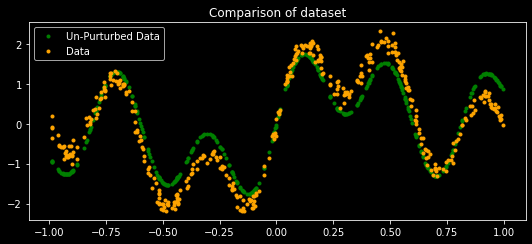

In [ ]:
pl.rcParams["figure.figsize"] = [7.50, 3.50]
pl.rcParams["figure.autolayout"] = True

def f(x):
    return np.sin(x)+np.sin(2*pi*x)+np.sin(5*pi*x)

pl.plot(x, f(x), '.', label = 'Un-Purturbed Data', color='green' )
pl.plot(x, y, '.', label = 'Data', color = 'orange')
pl.title('Comparison of dataset')
pl.legend()
pl.show()

In [ ]:
#_____________________PART-2.1_______________________
#Define the basis function:
#1. Polynomial basis
def poly_phi_x(x):
  pw = jnp.ones((6,))
  pw0 = 1
  pw1 = x[0]**1
  pw2 = x[0]**2
  pw3 = x[0]**3
  pw4 = x[0]**4
  pw5 = x[0]**5
  pw = pw.at[0].set(pw0)
  pw = pw.at[1].set(pw1)
  pw = pw.at[2].set(pw2)
  pw = pw.at[3].set(pw3)
  pw = pw.at[4].set(pw4)
  pw = pw.at[5].set(pw5)
  return pw

vec_poly_phi_x = vmap(poly_phi_x, in_axes=(0))

#_________________MLE_______________
X = vec_poly_phi_x(x)
#print(X.shape)
XT = X.T
#print(XT.shape)
X_inv = np.linalg.inv(jnp.matmul(XT, X))
w_MLE = jnp.matmul(jnp.matmul(X_inv, XT), y)
#print(w_MLE)
#_________________MAP__________________

l_inv = np.linalg.inv(jnp.matmul(XT, X) + b_a*jnp.eye(6,6))
print(l_inv.shape)
w_MAP = jnp.matmul(jnp.matmul(l_inv, XT), y)
#print(w_MAP)


(2, 400)
(2400,)
(400,)
(400,)


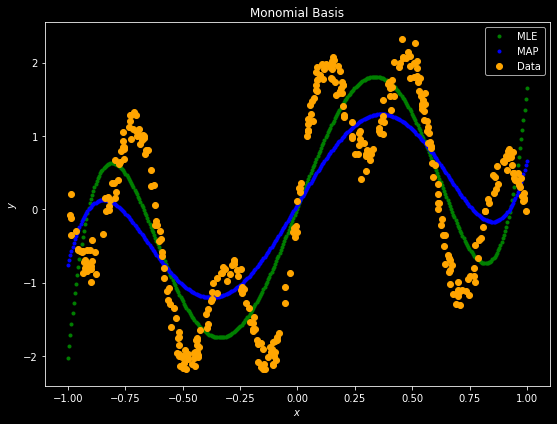

In [ ]:
# Predict at a set of test points
x_star = np.linspace(-1, 1, 400)[:,None]
X_star = vec_poly_phi_x(x_star)
Y_pred_MLE = X_star @ w_MLE
Y_pred_MAP = X_star @ w_MAP

mean_star = X_star @ w_MAP
var_star = 1/alpha + (X_star @ l_inv) @ X_star.T
key3 = random.PRNGKey(3)

num_samples = 100
samples = random.multivariate_normal(key, mean_star.flatten(), var_star, (num_samples,))
percentiles = np.percentile(samples, np.array([5.0, 95.0]), axis=0)
print(percentiles.shape)

print(X_star.flatten().shape)
print(percentiles[0, :].shape)
print(percentiles[1, :].shape)

plt.figure(1, figsize=(15, 6))
pl.subplot(1,2,1)
pl.plot(x_star, Y_pred_MLE, '.', label = 'MLE', color = 'green')
pl.plot(x_star, Y_pred_MAP, '.', label = 'MAP', color = 'blue')
pl.plot(x, y,'o', label = 'Data', color = 'orange')
plt.fill_between(x_star.flatten(), percentiles[0, :], percentiles[1, :], color='white')
pl.xlabel('$x$')
pl.ylabel('$y$')
pl.tight_layout()
pl.legend()
pl.title('Monomial Basis')
pl.show()



In [ ]:
#_____________________PART-2.2_______________________
#Define the basis function:
#2. Fourier Basis:
def F_phi_x(x):
  f = jnp.ones((12,))
  
  f0 = 0
  f1 = 1
  f2 = jnp.sin(pi*x[0])
  f3 = jnp.cos(pi*x[0])
  f4 = jnp.sin(2*pi*x[0])
  f5 = jnp.cos(2*pi*x[0])
  f6 = jnp.sin(3*pi*x[0])
  f7 = jnp.cos(3*pi*x[0])
  f8 = jnp.sin(4*pi*x[0])
  f9 = jnp.cos(4*pi*x[0])
  f10 = jnp.sin(5*pi*x[0])
  f11 = jnp.cos(6*pi*x[0])

  f = f.at[0].set(f0)
  f = f.at[1].set(f1)
  f = f.at[2].set(f2)
  f = f.at[3].set(f3)
  f = f.at[4].set(f4)
  f = f.at[5].set(f5)
  f = f.at[6].set(f6)
  f = f.at[7].set(f7)
  f = f.at[8].set(f8)
  f = f.at[9].set(f9)
  f = f.at[10].set(f10)
  f = f.at[11].set(f11)

  return f

vec_F_phi_x = vmap(F_phi_x, in_axes=(0))

#_________________MLE_______________
X = vec_F_phi_x(x)
#print(X.shape)
X_inv = np.linalg.pinv(X)
w_MLE = jnp.matmul(X_inv, y)

#_________________MAP__________________
XT = X.T
l_inv = np.linalg.inv(jnp.matmul(XT, X) + b_a*jnp.eye(12,12))
w_MAP = jnp.matmul(jnp.matmul(l_inv, XT), y)

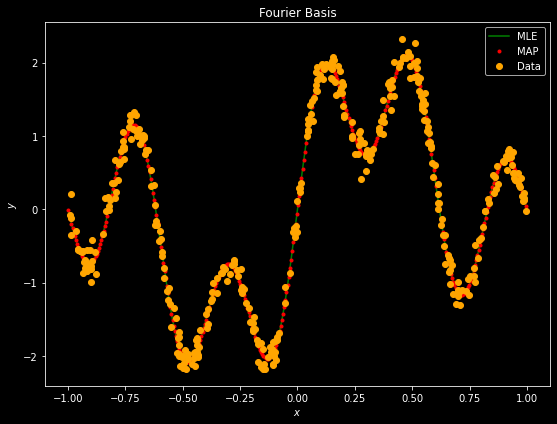

In [ ]:
#Plotting Output
# Predict at a set of test points
x_star = np.linspace(-1, 1, 400)[:,None]
X_star = vec_F_phi_x(x_star)

Y_pred_MLE = X_star @ w_MLE
Y_pred_MAP = X_star @ w_MAP

plt.figure(1, figsize=(15, 6))
pl.subplot(1,2,1)
pl.plot(x_star, Y_pred_MLE, '-', label = 'MLE', color = 'green')
pl.plot(x_star, Y_pred_MAP, '.', label = 'MAP', color='red')
plt.plot(x, y,'o', label = 'Data', color = 'orange')
#plt.fill_between(X_star.flatten(), percentiles[0, :], percentiles[1, :], color='lightblue')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.tight_layout()
pl.legend()
pl.title('Fourier Basis')
pl.show()

In [ ]:
#_____________________PART-2.3_______________________
#Define the basis function:
#3. Legendre Basis:
def L_phi_x(x):
  l = jnp.ones((6,))
  
  l0 = 1
  l1 = x[0]
  l2 = 3*x[0]**2 - 1
  l3 = 15*x[0]**3 - 7*x[0]
  l4 = 105*x[0]**4 - 58*x[0]**2 + 3
  l5 = 945*x[0]**5 - 582*x[0]**3 - 55*x[0]
  
  l = l.at[0].set(l0)
  l = l.at[1].set(l1)
  l = l.at[2].set(l2)
  l = l.at[3].set(l3)
  l = l.at[4].set(l4)
  l = l.at[5].set(l5)

  return l

vec_L_phi_x = vmap(L_phi_x, in_axes=(0))

#_________________MLE_______________
X = vec_L_phi_x(x)
X_inv = np.linalg.pinv(X)
w_MLE = jnp.matmul(X_inv, y)
#_________________MAP__________________
XT = X.T
l_inv = np.linalg.inv(jnp.matmul(XT, X) + b_a*jnp.eye(6,6))
w_MAP = jnp.matmul(jnp.matmul(l_inv, XT), y)

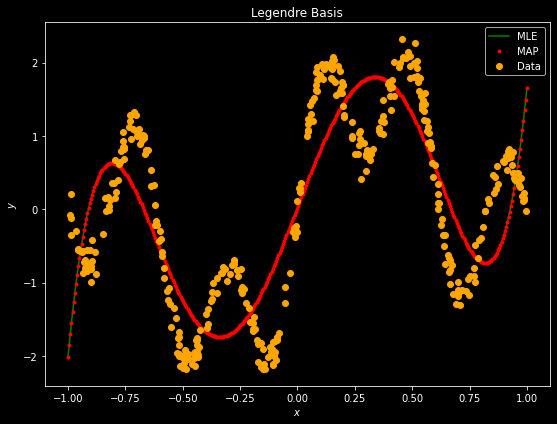

In [ ]:
#Plotting Output
# Predict at a set of test points
x_star = np.linspace(-1, 1, 400)[:,None]
X_star = vec_L_phi_x(x_star)

Y_pred_MLE = X_star @ w_MLE
Y_pred_MAP = X_star @ w_MAP

plt.figure(1, figsize=(15, 6))
pl.subplot(1,2,1)
pl.plot(x_star, Y_pred_MLE, '-', label = 'MLE', color = 'green')
pl.plot(x_star, Y_pred_MAP, '.', label = 'MAP', color='red')
plt.plot(x, y,'o', label = 'Data', color = 'orange')
#plt.fill_between(X_star.flatten(), percentiles[0, :], percentiles[1, :], color='lightblue')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.tight_layout()
pl.legend()
pl.title('Legendre Basis')
pl.show()

## Question 4 [20 Pts]:

Write a logistic regression model to classify the letters from the [EMNIST](https://www.nist.gov/itl/products-and-services/emnist-dataset) letters dataset. Create an 80/20 train/test split of the data. You've been provided a template to carry this out. Fill in the suitable sections of the code.

- First train your model to perform binary classification between the letters b and d. Visualize performance on the training and test sets using a confusion matrix.
- Next, train your model to perform multiclass classification between b, d, p and q. Visualize performance on the training and test sets using a confusion matrix. 

In [ ]:
import torchvision
import jax.numpy as jnp
import jax
import matplotlib.pyplot as pl
import seaborn as sns
from sklearn import metrics
from sklearn.model_selection import train_test_split

In [ ]:
dataset = torchvision.datasets.EMNIST(root='./', split='letters', train=True, download=True)

  0%|          | 0/561753746 [00:00<?, ?it/s]

Extracting ./EMNIST/raw/gzip.zip to ./EMNIST/raw


In [ ]:
X = jnp.array(dataset.data)
y = jnp.array(dataset.targets)
#print(dataset.classes)
#print(X[1, :, :])
#print(y.shape)
# Fill in the code below to get letter b, d, p and q from the dataset
i_b = jnp.where(y == 2)[0]
i_d = jnp.where(y == 4)[0]
i_p = jnp.where(y == 16)[0]
i_q = jnp.where(y == 17)[0]

X_b = X[i_b]
X_d = X[i_d]
X_p = X[i_p]
X_q = X[i_q]

Y_b = y[i_b]
Y_d = y[i_d]
Y_p = y[i_p]
Y_q = y[i_q]


# Combine them below to create datasets for usage in following parts
# create X_bd, Y_bd for binary classification
X_bd = jnp.concatenate((X_b, X_d), axis = 0)
Y_bd = jnp.concatenate((Y_b, Y_d), axis = 0)
# create X_bdpq, Y_bdpq for multiclass classification
X_bdpq = jnp.concatenate((X_b, X_d, X_p, X_q), axis = 0)
Y_bdpq = jnp.concatenate((Y_b, Y_d, Y_p, Y_q), axis = 0)

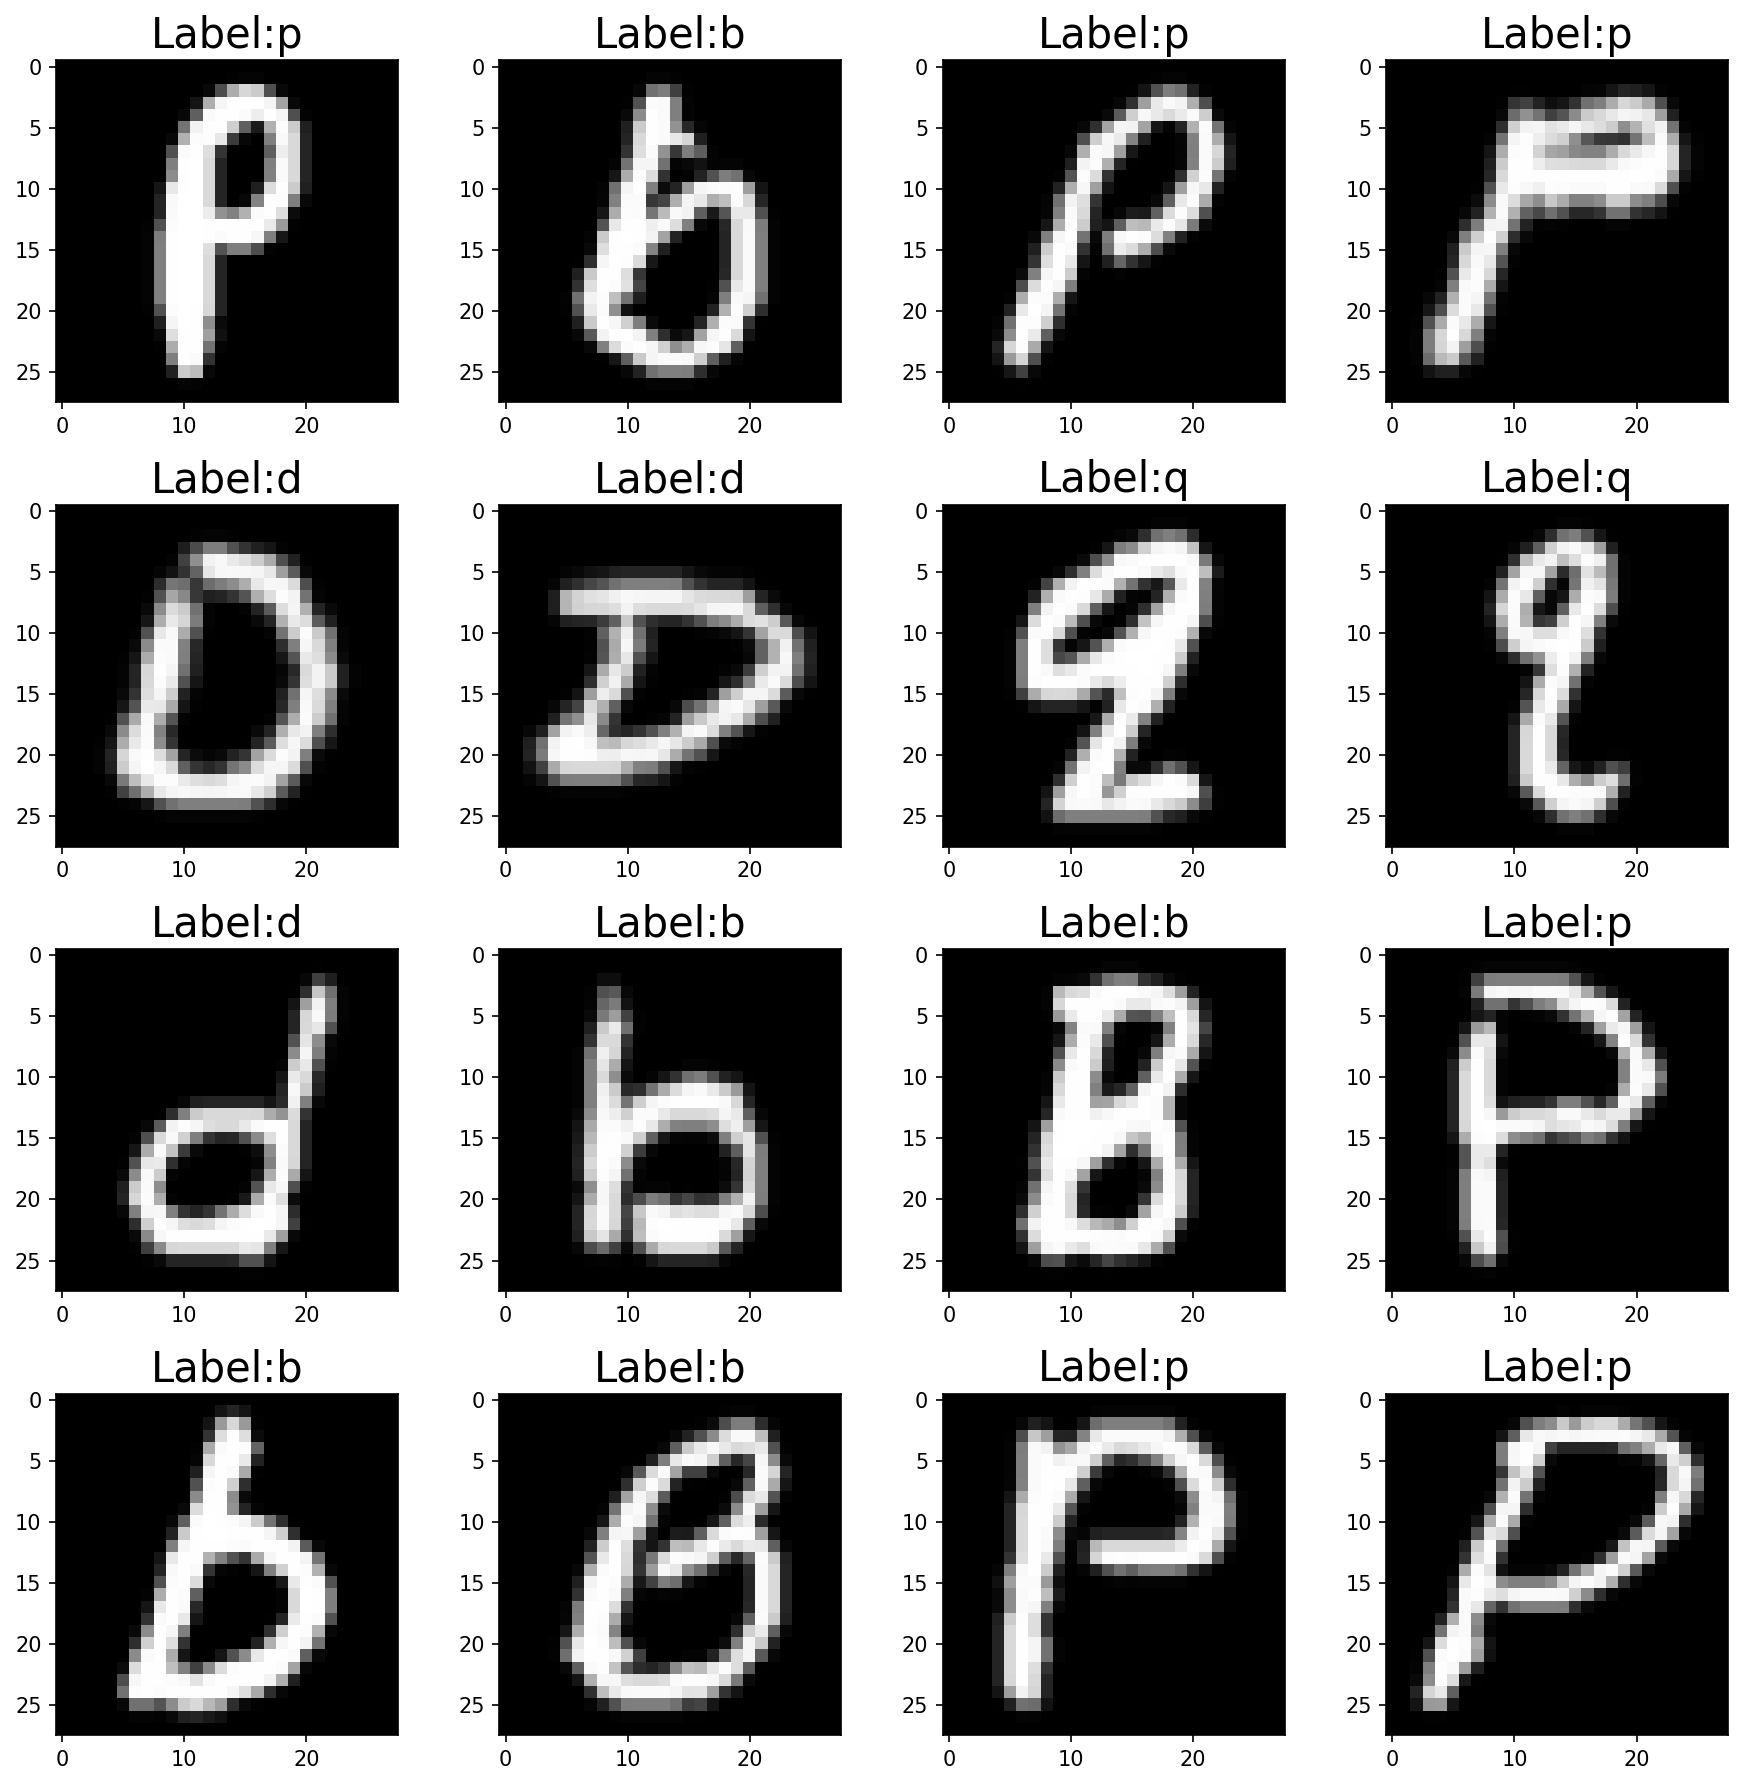

In [ ]:
# Check that the mapping was performed correctly by utilizing a few examples:
# Visualizing that your mapping is performed correctly
rnd_idx = jax.random.randint(jax.random.PRNGKey(56), (16,), 0, X_bdpq.shape[0])
# assuming that the labels are mapped as follows: b -> 2, d -> 4, p -> 16, q -> 17
str_labels = {'2' : 'b', '4' : 'd', '16':'p', '17':'q'}
pl.figure(dpi = 150, figsize=(12,12))
for index, (image, label) in enumerate(zip(X_bdpq[rnd_idx], Y_bdpq[rnd_idx])):
    pl.subplot(4, 4, index + 1)
    pl.imshow(jnp.reshape(image, (28, 28)).T, cmap=pl.cm.gray)
    pl.title('Label:' + str_labels[str(label)], fontsize = 20)
pl.tight_layout()

In [ ]:
# Fill in the code to perform an 80-20 train-test split on X_bd and y_bd to yield X_train, y_train, X_test, y_test:
X_train, X_test, Y_train, Y_test = train_test_split(X_bd, Y_bd, test_size=0.2, random_state=42)

X_train = X_train.reshape(X_train.shape[0], 28*28)
X_test = X_test.reshape(X_test.shape[0], 28*28)

Y_train = Y_train.at[Y_train == 2].set(0)
Y_test = Y_test.at[Y_test == 2].set(0)
Y_train = Y_train.at[Y_train == 4].set(1)
Y_test = Y_test.at[Y_test == 4].set(1)

Y_train = jnp.expand_dims(Y_train, axis=1)
Y_test = jnp.expand_dims(Y_test, axis=1)

In [ ]:
def forward(params, X):
    return jax.nn.sigmoid(X @ params)

@jax.jit
def loss_fn(params, X, y):
  al = forward(params, X)
  loss = -jnp.mean((y * jnp.log(al+1e-8)) + (1-y) * jnp.log(1-al+1e-8))
  return loss

# Computing Gradients:
grad_loss = jax.jit(jax.grad(loss_fn))

In [ ]:
# Initializing weights as zeros:
params = jnp.zeros([784, 1])
#print(grad_loss(params, X_train, Y_train).shape)
# Gradient descent
# Learning Rate

alpha = 5e-6
n_its = 5000

loss_history = [loss_fn(params, X_train, Y_train)]

for i in range(n_its):
  #print("params", params[5])
  #print("loss", loss_fn(params, X_train, Y_train))
  g      = grad_loss(params, X_train, Y_train)
  
  
  #print("grad", g[5])
  #print("alpha_g", alpha*g[5])
  params = jax.tree_map(lambda x, g: x - alpha * g, params, g)
  #print("params", params[5])
  #print("\n")
  # Track progress:
  loss_history = loss_history + [loss_fn(params, X_train, Y_train)]
  # if i % 5 == 0:
  #   print('iter', i, 'loss', loss_fn(params, X_train, Y_train))

Text(0.5, 0, 'Number of Iterations')

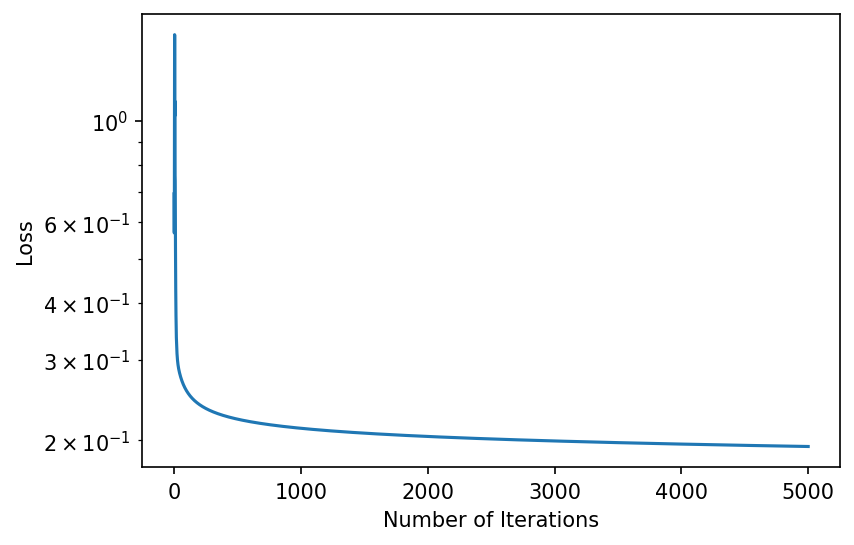

In [ ]:
# Plotting the loss history
pl.figure(dpi = 150)
pl.semilogy(loss_history)
pl.ylabel('Loss')
pl.xlabel('Number of Iterations')

In [ ]:
# Computing Accuracy Score and Resulting Confusion Matrix for test set:
accuracy_score = (jnp.round(forward(params, X_test)).ravel() == Y_test).mean()
cm             = metrics.confusion_matrix(Y_test, jnp.round(forward(params, X_test)))
cm_normalized  = cm.astype('float') / cm.sum(axis=1)[:, jnp.newaxis]

print('Accuracy Score on Test Set:', accuracy_score)

Accuracy Score on Test Set: 0.5001649


Text(0.5, 1.0, 'Confusion Matrix')

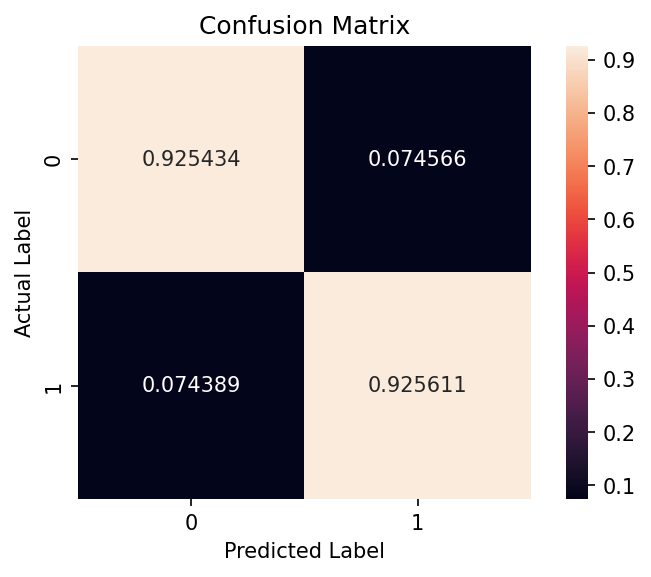

In [ ]:
pl.figure(dpi = 150)
sns.heatmap(cm_normalized, fmt = '4f', annot = True, square = True);
pl.ylabel('Actual Label');
pl.xlabel('Predicted Label');
pl.title('Confusion Matrix')

In [ ]:
# Fill in the code to perform an 80-20 train-test split on X_bdpq and y_bdpq to yield X_train, y_train, X_test, y_test:
X_train, X_test, Y_train, Y_test = train_test_split(X_bdpq, Y_bdpq, test_size=0.2, random_state=40)

X_train = X_train.reshape(X_train.shape[0], 28*28)
X_test = X_test.reshape(X_test.shape[0], 28*28)

Y_train = Y_train.at[Y_train == 2].set(0)
Y_test = Y_test.at[Y_test == 2].set(0)
Y_train = Y_train.at[Y_train == 4].set(1)
Y_test = Y_test.at[Y_test == 4].set(1)
Y_train = Y_train.at[Y_train == 16].set(2)
Y_test = Y_test.at[Y_test == 16].set(2)
Y_train = Y_train.at[Y_train == 17].set(3)
Y_test = Y_test.at[Y_test == 17].set(3)

#One hot encoding:
Y_train = jax.nn.one_hot(Y_train, 4)
Y_test = jax.nn.one_hot(Y_test, 4)


In [ ]:
def forward(params, X):
    return jax.nn.softmax(X @ params)
# params = jnp.zeros([784, 4])
# sm = forward(params, X_train)

@jax.jit
def loss_fn(params, X, y):
  sft_max = forward(params, X)
  loss  = -jnp.mean(y * jnp.log(sft_max))
  return loss

# Computing Gradients:
grad_loss = jax.jit(jax.grad(loss_fn))

In [ ]:
# Initializing weights as zeros:
params = jnp.zeros([784, 4])

# Gradient descent
# Learning Rate
alpha = 1e-6
n_its = 50000

loss_history = [loss_fn(params, X_train, Y_train)]
for i in range(n_its):
    g      = grad_loss(params, X_train, Y_train)
    params = jax.tree_map(lambda x, g: x - alpha * g, params, g)

    # Track progress:
    loss_history = loss_history + [loss_fn(params, X_train, Y_train)]

Text(0.5, 0, 'Number of Iterations')

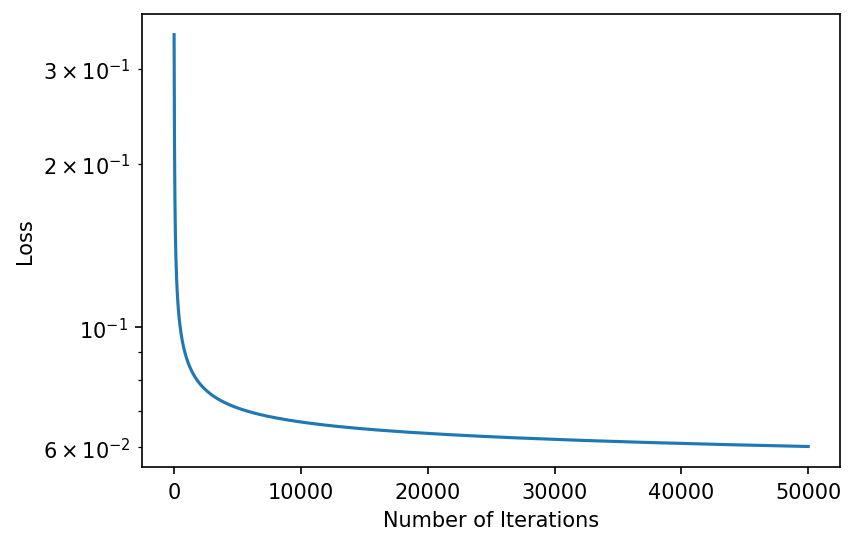

In [ ]:
pl.figure(dpi = 150)
pl.semilogy(loss_history)
pl.ylabel('Loss')
pl.xlabel('Number of Iterations')

In [ ]:
# Computing Accuracy Score and Resulting Confusion Matrix for test set:
accuracy_score = (jnp.argmax(forward(params, X_test), axis = 1) == 
                  jnp.argmax(Y_test, axis = 1)).mean()
cm             = metrics.confusion_matrix(jnp.argmax(Y_test, axis = 1), 
                                          jnp.argmax(forward(params, X_test), axis = 1))
cm_normalized  = cm.astype('float') / cm.sum(axis=1)[:, jnp.newaxis]
print('Accuracy Score on Test Set:', accuracy_score)

Accuracy Score on Test Set: 0.9065105


Text(0.5, 1.0, 'Confusion Matrix')

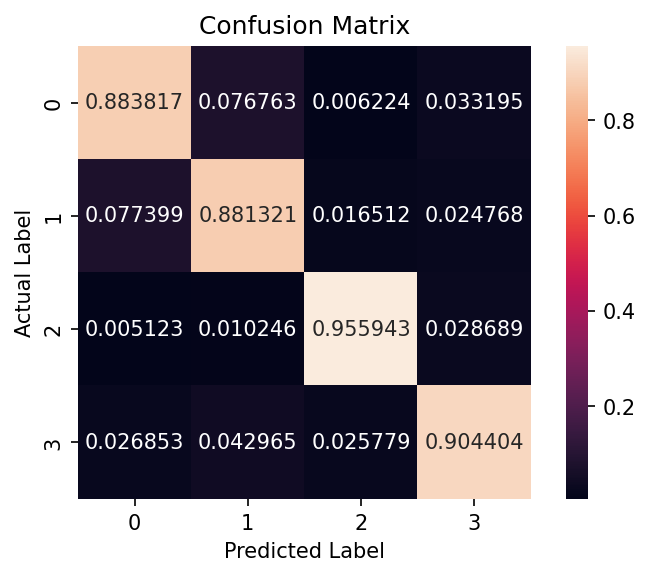

In [ ]:
pl.figure(dpi = 150)
sns.heatmap(cm_normalized, fmt = '4f', annot = True, square = True);
pl.ylabel('Actual Label');
pl.xlabel('Predicted Label');
pl.title('Confusion Matrix')

## Question 5 [20 Pts]:
Write Python routines:
- `gradient_descent(f, g, x0, eta)` that performs an iteration of gradient descent on a given function $f(x)$ and its gradient $g(x)$, starting at a given point $x_0$, and using a given step-size $\eta$.
- `newton(f, g, H, x0, eta)` that performs an iteration of Newton's method on a given function $f(x)$, its gradient $g(x)$ and Hessian $H(x)$, starting at a given point $x_0$, and using a given step-size $\eta$.

Do **NOT** use `jax.grad` or `jax.hessian` (you need to define the gradient and Hessian functions). Use those routines in an optimization loop to optimize the following two functions:

- $$f_1(x, y) = x^2 + 100 y^2 $$
- $$f_2(x, y) = (1 - x)^2 + 100(y - x^2)^2,$$

Consider step-sizes $\eta = 0.001, 0.01, 1$. Take your initial starting location as $(-1, 1)$. Comment on the following: 
- What is the effect of step-size on the different problems, and algorithms? 
- When the algorithm does converge, how many steps does it take to reach the minimum?

Give suitable reasons for your observations. Plot the objective function value vs the iterate number, and a plot that shows the progress on a contour plot of the landscape. Use these to support your reasoning.

In [ ]:
import numpy as np
from numpy import pi
import jax.numpy as jnp   
from jax import grad, jacfwd, jit, random, vmap
from jax.scipy.stats import multivariate_normal
from jax.tree_util import tree_map
from numpy.matrixlib import mat
from jax._src.numpy.ufuncs import square
from IPython.display import clear_output
import matplotlib.pyplot as plt
from matplotlib import style
style.use('dark_background')

In [ ]:
def gradient_descent(f, g, x0, eta):  
  grad = g(x0)
  x_new = x0 - grad * eta
  return x_new

def newton(f, g, H, x0, eta):
  x0 = np.array(x0)
  grad = np.array(g(x0))
  hessian = np.array(H(x0))
  h_inv = jnp.linalg.inv(hessian)
  x_new = x0 - eta * h_inv @ grad.T
  x0 = x_new
  return x_new


def f1(x0):
  f = x0[0]**2 + 100*x0[1]**2
  return f
def g1(x0):
  g = np.array([2*x0[0], 200*x0[1]])
  return g
def H1(x0):
  H = np.array([[2, 0], [0, 200]])
  return H


def f2(x0):
  f = 100*x0[0]**4 + x0[0]**2 + 100*x0[1]**2 - 200*x0[0]**2*x0[1] - 2*x0[0] + 1
  return f
def g2(x0):
  g = np.array([400*x0[0]**3 - 400*x0[0]*x0[1] + 2*x0[0] - 2, 200*x0[1] -200*x0[0]**2])
  return g
def H2(x0):
  H = np.array([[1200*x0[0]**2 - 400*x0[1] + 2, -400*x0[0]], [-400*x0[0], 200]])
  return H


Number of iterations required to converge:
1. Newton's method is converges with lesser number of iterations provided we use a best value of step size. Not too large, not too small.

2. Gradient descent converges based on step size. If step size selection goes wrong, it doesn't converge even if we increase the number of iterations. We have to keep on decreasing the step size until it converges.

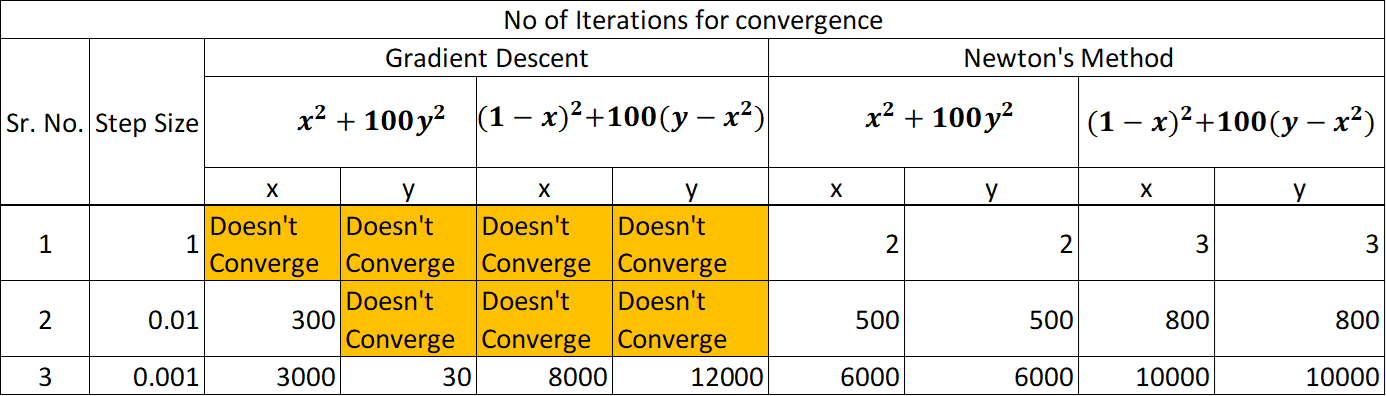

<ipython-input-87-179b383f5184>:19: RuntimeWarning: overflow encountered in long_scalars
  g = np.array([2*x0[0], 200*x0[1]])


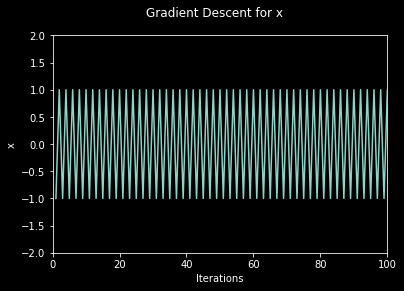

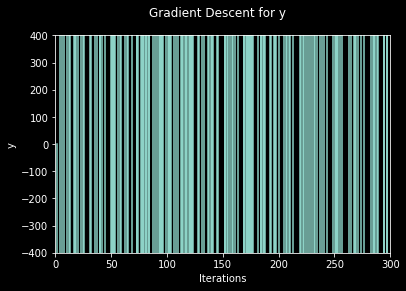

In [ ]:
#________________________Gradient_Descent: Function 1, eta = 1_____________________________

  #initialize x:
x0 = [-1, 1]
iter = 100
n_iter = list(range(1, iter+2))
x_history = [-1]

#Run the gradient descent:
for i in range(iter):
  x_new = gradient_descent(f1, g1, x0, 1)
  x0 = x_new
  x_history.append(x_new[0])
X1_g = x_history

# Plotting the x history
pl.suptitle('Gradient Descent for x')
pl.plot(n_iter, X1_g)
pl.axis([0, 100, -2, 2])
pl.xlabel('Iterations')
pl.ylabel('x')
pl.show()


y_history = [1]
for i in range(300):
  x_new = gradient_descent(f1, g1, x0, 1)
  x0 = x_new
  y_history.append(x_new[1])
Y1_g = y_history

n_iter_y = list(range(1, 302))
pl.suptitle('Gradient Descent for y')
pl.plot(n_iter_y, Y1_g)
pl.axis([0, 300, -400, 400])
pl.xlabel('Iterations')
pl.ylabel('y')
pl.show()


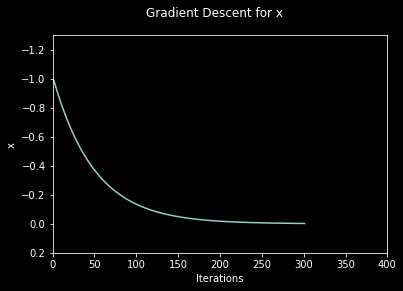

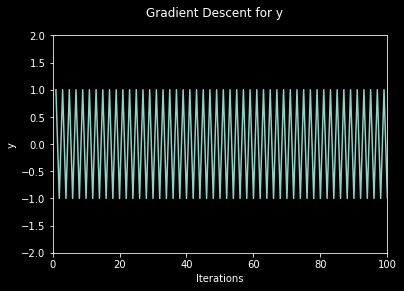

In [ ]:
#________________________Gradient_Descent: Function 1, eta = 0.01_____________________________

  #initialize x:
x0 = [-1, 1]
iter = 300
n_iter = list(range(1, iter+2))
x_history = [-1]
y_history = [1]

#Run the gradient descent:
for i in range(iter):
  x_new = gradient_descent(f1, g1, x0, 0.01)
  x0 = x_new
  x_history.append(x_new[0])
  y_history.append(x_new[1])
X1_g = x_history
Y1_g = y_history

# Plotting the x and y history
pl.suptitle('Gradient Descent for x')
pl.plot(n_iter, X1_g)
pl.axis([0, 400, 0.2, -1.3])
pl.xlabel('Iterations')
pl.ylabel('x')
pl.show()

pl.suptitle('Gradient Descent for y')
pl.plot(n_iter, Y1_g)
pl.axis([0, 100, -2, 2])
pl.xlabel('Iterations')
pl.ylabel('y')
pl.show()

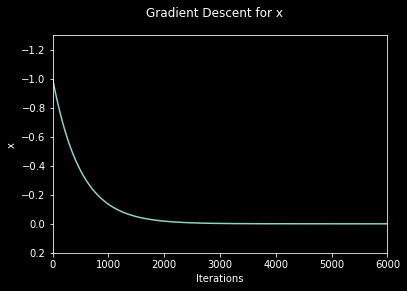

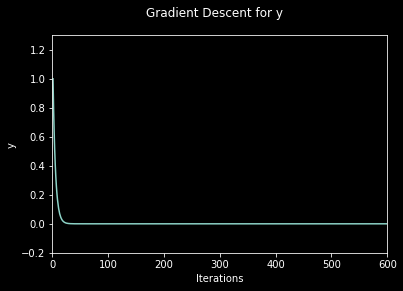

In [ ]:
#________________________Gradient_Descent: Function 1, eta = 0.001_____________________________

  #initialize x:
x0 = [-1, 1]
iter = 6000
n_iter = list(range(1, iter+2))
x_history = [-1]
y_history = [1]

#Run the gradient descent:
for i in range(iter):
  x_new = gradient_descent(f1, g1, x0, 0.001)
  x0 = x_new
  x_history.append(x_new[0])
  y_history.append(x_new[1])
X1_g = x_history
Y1_g = y_history

# Plotting the x and y history
pl.suptitle('Gradient Descent for x')
pl.plot(n_iter, X1_g)
pl.axis([0, 6000, 0.2, -1.3])
pl.xlabel('Iterations')
pl.ylabel('x')
pl.show()

pl.suptitle('Gradient Descent for y')
pl.plot(n_iter, Y1_g)
pl.axis([0, 600, -0.2, 1.3])
pl.xlabel('Iterations')
pl.ylabel('y')
pl.show()

<ipython-input-111-fd75944a1d57>:9: RuntimeWarning: overflow encountered in long_scalars
  g = np.array([400*x0[0]**3 - 400*x0[0]*x0[1] + 2*x0[0] - 2, 200*x0[1] -200*x0[0]**2])


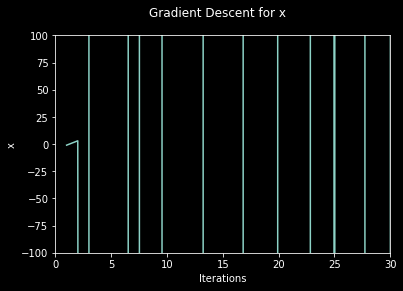

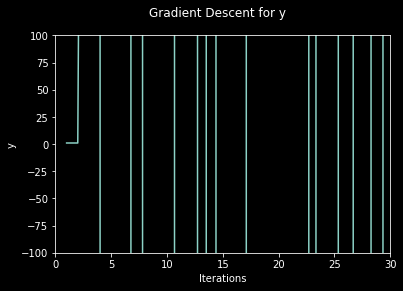

In [ ]:
#________________________Gradient_Descent: Function 2, eta = 1_____________________________

#initialize x:

x0 = [-1, 1]
iter = 30
n_iter = list(range(1, iter+2))
x_history = [-1]
y_history = [1]

#Run the gradient descent:
for i in range(iter):
  x_new = gradient_descent(f2, g2, x0, 1)
  x0 = x_new
  x_history.append(x_new[0])
  y_history.append(x_new[1])
X2_g = x_history
Y2_g = y_history

# Plotting the x and y history
pl.suptitle('Gradient Descent for x')
pl.plot(n_iter, X2_g)
pl.axis([0, 30, -100, 100])
pl.xlabel('Iterations')
pl.ylabel('x')
pl.show()

pl.suptitle('Gradient Descent for y')
pl.plot(n_iter, Y2_g)
pl.axis([0, 30, -100, 100])
pl.xlabel('Iterations')
pl.ylabel('y')
pl.show()


[-1, -0.96, -1.2218560000000003, 1.9980973045087649, -12.8056161104943, 8087.877202928909, -2116223327838.662, 3.7909188137332987e+37, -2.1791816958632584e+113, inf, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
[1, 1.0, 0.8432, 2.1426641694720012, 5.842121507098383, 322.125486431604, 130827193.1738279, 8.956802346577084e+24, 2.8742130904634163e+75, 9.497665727170933e+226, inf, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]


<ipython-input-111-fd75944a1d57>:9: RuntimeWarning: overflow encountered in double_scalars
  g = np.array([400*x0[0]**3 - 400*x0[0]*x0[1] + 2*x0[0] - 2, 200*x0[1] -200*x0[0]**2])
<ipython-input-111-fd75944a1d57>:9: RuntimeWarning: invalid value encountered in double_scalars
  g = np.array([400*x0[0]**3 - 400*x0[0]*x0[1] + 2*x0[0] - 2, 200*x0[1] -200*x0[0]**2])


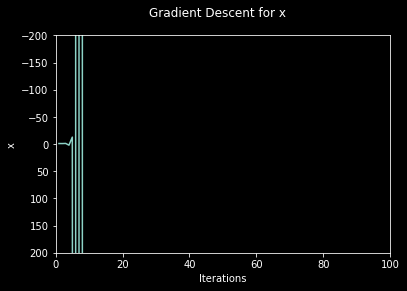

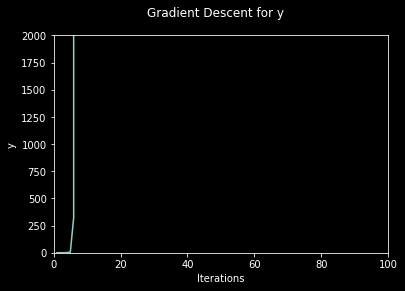

In [ ]:
#________________________Gradient_Descent: Function 2, eta = 0.01_____________________________

#initialize x:
x0 = [-1, 1]
iter = 50
n_iter = list(range(1, iter+2))
x_history = [-1]
y_history = [1]

#Run the gradient descent:
for i in range(iter):
  x_new = gradient_descent(f2, g2, x0, 0.01)
  x0 = x_new
  x_history.append(x_new[0])
  y_history.append(x_new[1])
X2_g = x_history
Y2_g = y_history

# Plotting the x and y history
pl.suptitle('Gradient Descent for x')
pl.plot(n_iter, X2_g)
pl.axis([0, 100, 200, -200])
pl.xlabel('Iterations')
pl.ylabel('x')
pl.show()

pl.suptitle('Gradient Descent for y')
pl.plot(n_iter, Y2_g)
pl.axis([0, 100, 0, 2000])
pl.xlabel('Iterations')
pl.ylabel('y')
pl.show()


[-1, -0.996, -0.9951888256, -0.9943840081296537, -0.9935785274699253, -0.9927723306113927, -0.9919654154660804, -0.9911577803777838, -0.9903494236887816, -0.9895403437355399, -0.9887305388486375, -0.9879200073527379, -0.9871087475665624, -0.9862967578028621, -0.9854840363683904, -0.9846705815638754, -0.9838563916839916, -0.983041465017332, -0.9822257998463796, -0.9814093944474792, -0.9805922470908086, -0.9797743560403501, -0.9789557195538614, -0.9781363358828462, -0.9773162032725257, -0.9764953199618087, -0.9756736841832622, -0.9748512941630813, -0.9740281481210599, -0.9732042442705604, -0.9723795808184834, -0.9715541559652373, -0.9707279679047075, -0.9699010148242265, -0.969073294904542, -0.9682448063197865, -0.9674155472374455, -0.9665855158183267, -0.965754710216528, -0.9649231285794058, -0.9640907690475427, -0.9632576297547162, -0.9624237088278654, -0.9615890043870596, -0.9607535145454643, -0.9599172374093096, -0.9590801710778561, -0.9582423136433627, -0.9574036631910522, -0.956564

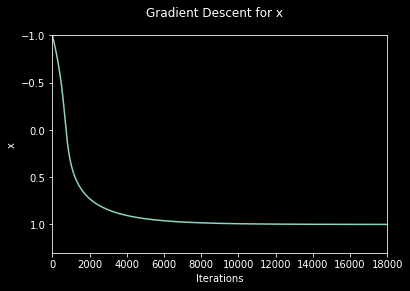

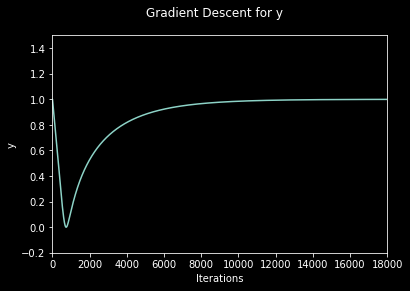

In [ ]:
#________________________Gradient_Descent: Function 2, eta = 0.001_____________________________

#initialize x:
x0 = [-1, 1]
iter = 18000
n_iter = list(range(1, iter+2))
x_history = [-1]
y_history = [1]

#Run the gradient descent:
for i in range(iter):
  x_new = gradient_descent(f2, g2, x0, 0.001)
  x0 = x_new
  x_history.append(x_new[0])
  y_history.append(x_new[1])
X2_g = x_history
Y2_g = y_history


# Plotting the x and y history
pl.suptitle('Gradient Descent for x')
pl.plot(n_iter, X2_g)
pl.axis([0, 18000, 1.3, -1])
pl.xlabel('Iterations')
pl.ylabel('x')
pl.show()

pl.suptitle('Gradient Descent for y')
pl.plot(n_iter, Y2_g)
pl.axis([0, 18000, -0.2, 1.5])
pl.xlabel('Iterations')
pl.ylabel('y')
pl.show()


## **Newton's Method**






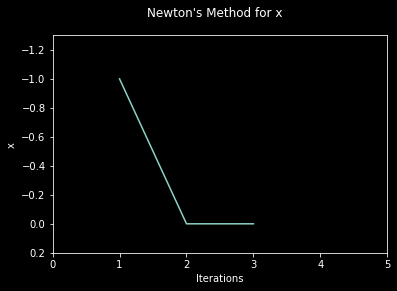

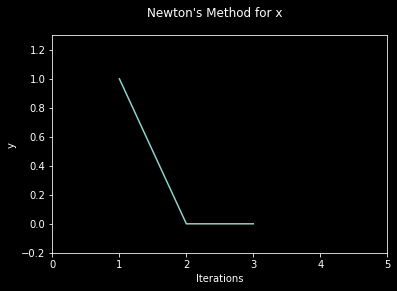

In [ ]:
#________________________Newton's Method: Function 1, eta = 1_____________________________

#initialize x:
x0 = [-1, 1]
iter = 2
n_iter = list(range(1, iter+2))
x_history = [-1]
y_history = [1]

#Run the gradient descent:
for i in range(iter):
  x_new = newton(f1, g1, H1, x0, 1)
  x0 = x_new
  x_history.append(x_new[0])
  y_history.append(x_new[1])

X1_n = x_history
Y1_n = y_history


# Plotting the x and y history
pl.suptitle('Newton\'s Method for x')
pl.plot(n_iter, X1_n)
pl.axis([0, 5, 0.2, -1.3])
pl.xlabel('Iterations')
pl.ylabel('x')
pl.show()

pl.suptitle('Newton\'s Method for y')
pl.plot(n_iter, Y1_n)
pl.axis([0, 5, -0.2, 1.3])
pl.xlabel('Iterations')
pl.ylabel('y')
pl.show()

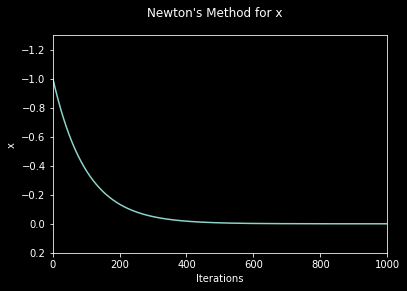

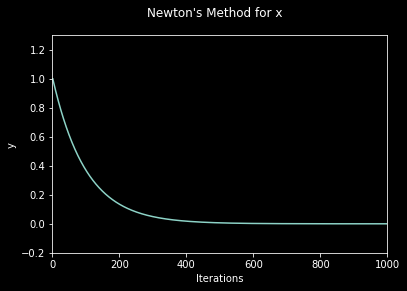

In [ ]:
#________________________Newton's Method: Function 1, eta = 0.01_____________________________

#initialize x:
x0 = [-1, 1]
iter = 1000
n_iter = list(range(1, iter+2))
x_history = [-1]
y_history = [1]

#Run the gradient descent:
for i in range(iter):
  x_new = newton(f1, g1, H1, x0, 0.01)
  x0 = x_new
  x_history.append(x_new[0])
  y_history.append(x_new[1])

X1_n = x_history
Y1_n = y_history


# Plotting the x and y history
pl.suptitle('Newton\'s Method for x')
pl.plot(n_iter, X1_n)
pl.axis([0, 1000, 0.2, -1.3])
pl.xlabel('Iterations')
pl.ylabel('x')
pl.show()

pl.suptitle('Newton\'s Method for y')
pl.plot(n_iter, Y1_n)
pl.axis([0, 1000, -0.2, 1.3])
pl.xlabel('Iterations')
pl.ylabel('y')
pl.show()

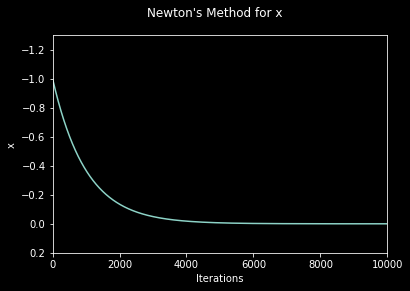

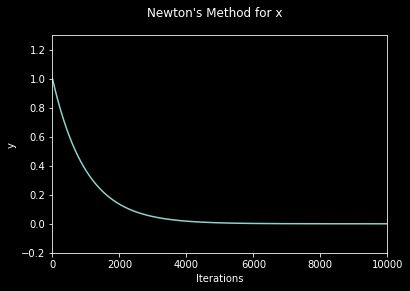

In [ ]:
#________________________Newton's Method: Function 1, eta = 0.001_____________________________

#initialize x:
x0 = [-1, 1]
iter = 10000
n_iter = list(range(1, iter+2))
x_history = [-1]
y_history = [1]

#Run the gradient descent:
for i in range(iter):
  x_new = newton(f1, g1, H1, x0, 0.001)
  x0 = x_new
  x_history.append(x_new[0])
  y_history.append(x_new[1])

X1_n = x_history
Y1_n = y_history


# Plotting the x and y history
pl.suptitle('Newton\'s Method for x')
pl.plot(n_iter, X1_n)
pl.axis([0, 10000, 0.2, -1.3])
pl.xlabel('Iterations')
pl.ylabel('x')
pl.show()

pl.suptitle('Newton\'s Method for y')
pl.plot(n_iter, Y1_n)
pl.axis([0, 10000, -0.2, 1.3])
pl.xlabel('Iterations')
pl.ylabel('y')
pl.show()

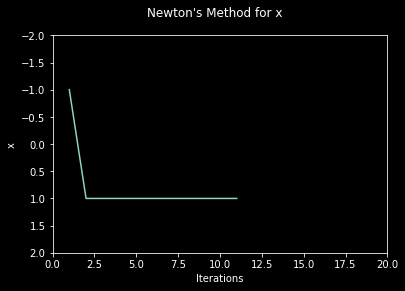

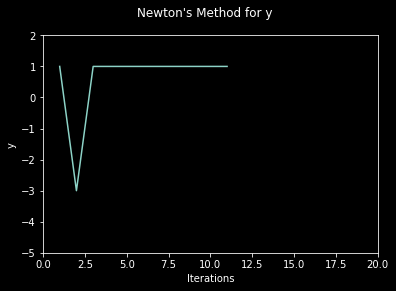

In [ ]:
#________________________Newton's Method: Function 2, eta = 1_____________________________

#initialize x:
x0 = [-1, 1]
iter = 10
n_iter = list(range(1, iter+2))
x_history = [-1]
y_history = [1]

#Run the gradient descent:
for i in range(iter):
  x_new = newton(f2, g2, H2, x0, 1)
  x0 = x_new
  x_history.append(x_new[0])
  y_history.append(x_new[1])

X2_n = x_history
Y2_n = y_history


# Plotting the x and y history
pl.suptitle('Newton\'s Method for x')
pl.plot(n_iter, X2_n)
pl.axis([0, 20, 2, -2])
pl.xlabel('Iterations')
pl.ylabel('x')
pl.show()

pl.suptitle('Newton\'s Method for y')
pl.plot(n_iter, Y2_n)
pl.axis([0, 20, -5, 2])
pl.xlabel('Iterations')
pl.ylabel('y')
pl.show()

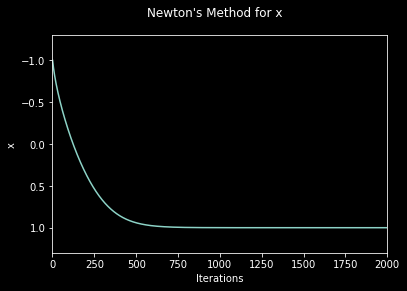

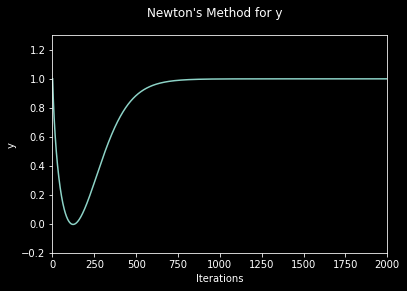

In [ ]:
#________________________Newton's Method: Function 2, eta = 0.01_____________________________

#initialize x:
x0 = [-1, 1]
iter = 2000
n_iter = list(range(1, iter+2))
x_history = [-1]
y_history = [1]

#Run the gradient descent:
for i in range(iter):
  x_new = newton(f2, g2, H2, x0, 0.01)
  x0 = x_new
  x_history.append(x_new[0])
  y_history.append(x_new[1])

X1_n = x_history
Y1_n = y_history


# Plotting the x and y history
pl.suptitle('Newton\'s Method for x')
pl.plot(n_iter, X1_n)
pl.axis([0, 2000, 1.3, -1.3])
pl.xlabel('Iterations')
pl.ylabel('x')
pl.show()

pl.suptitle('Newton\'s Method for y')
pl.plot(n_iter, Y1_n)
pl.axis([0, 2000, -0.2, 1.3])
pl.xlabel('Iterations')
pl.ylabel('y')
pl.show()

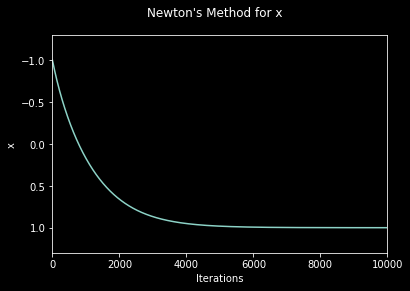

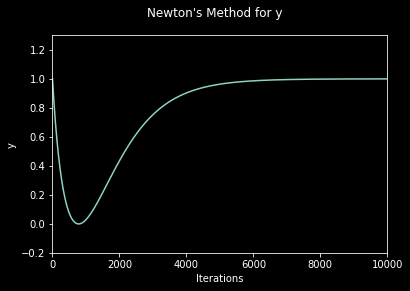

In [ ]:
#________________________Newton's Method: Function 2, eta = 0.001_____________________________

#initialize x:
x0 = [-1, 1]
iter = 10000
n_iter = list(range(1, iter+2))
x_history = [-1]
y_history = [1]

#Run the gradient descent:
for i in range(iter):
  x_new = newton(f2, g2, H2, x0, 0.001)
  x0 = x_new
  x_history.append(x_new[0])
  y_history.append(x_new[1])

X1_n = x_history
Y1_n = y_history


# Plotting the x and y history
pl.suptitle('Newton\'s Method for x')
pl.plot(n_iter, X1_n)
pl.axis([0, 10000, 1.3, -1.3])
pl.xlabel('Iterations')
pl.ylabel('x')
pl.show()

pl.suptitle('Newton\'s Method for y')
pl.plot(n_iter, Y1_n)
pl.axis([0, 10000, -0.2, 1.3])
pl.xlabel('Iterations')
pl.ylabel('y')
pl.show()